# Instagram Influencers Analysis
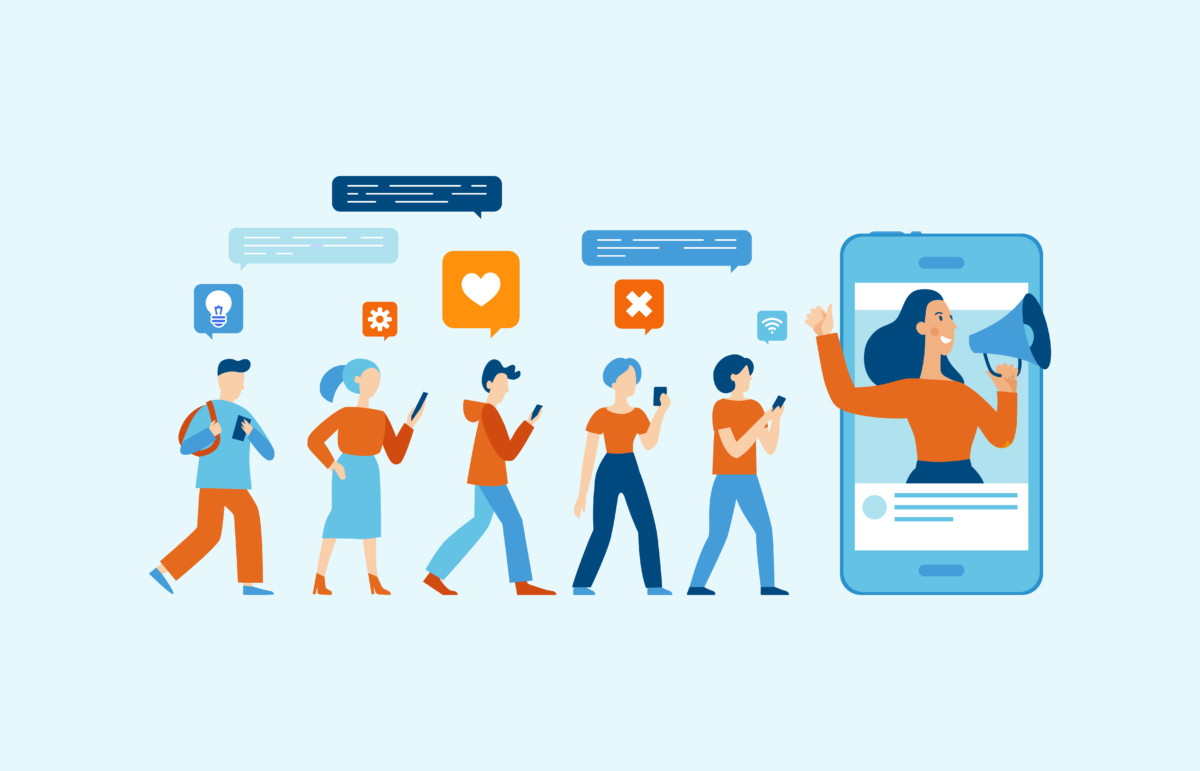

## Context
* Instagram is one of the most popular social media websites with about 1 billion active users. 
* Instagram marketing has proliferated as a source for companies to market their products with one way known as Brand-sponsored post.
* This involves Instagram users known as "Influencers" to post about a brand or particular product in exchange for a fee/gift for the post.

**This project aims to identify whether a post is sponsored, who the sponsor is and develop a Recommender System.**

In [51]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
import spacy
import re
from pytrends.request import TrendReq
import datetime
import time
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
init_notebook_mode(connected=True)

pd.set_option('display.max_rows', 500)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Calven\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Calven\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Calven\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Calven\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Calven\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [52]:
influencers_raw = pd.read_csv("C:/Users/Calven/Documents/Projects\data/influencers.csv",encoding='ISO 8859-1')
orgcorpus_raw = pd.read_csv("C:/Users/Calven/Documents/Projects\data/orgcorpus.txt", sep=",", header=None).values.tolist()[0]

influencers_raw.head()
influencers_raw.describe()

,id,User,Followers,Postdate,Likes,Comments,Caption,Industry,Country
0,1,alinagavrilov_,101622.0,24/11/2021 3:26,857.0,15,Layered neutrals Ã°Å¸âÂ¤ who else has been l...,Fashion,United States
1,2,alinagavrilov_,101622.0,21/11/2021 21:21,576.0,34,When in doubt Ã°Å¸Â¤Å½ @mango has been killing...,Fashion,United States
2,3,alinagavrilov_,101622.0,16/11/2021 2:13,937.0,32,Back to my classic combo Ã°Å¸Â¤Å½ linking some...,Fashion,United States
3,4,alinagavrilov_,101622.0,15/11/2021 1:30,1097.0,54,Pop of Ã°Å¸Â§Â¡ to match the Ã°Å¸ÂÂÃ°Å¸Ââ...,Fashion,United States
4,5,alinagavrilov_,101622.0,13/11/2021 18:04,383.0,28,Sweater vest club Ã°Å¸ÂâÃ°Å¸ÂÂ happy Satu...,Fashion,United States


,id,Followers,Likes,Comments
count,2602.000000,2.592000e+03,2547.000000,2602.000000
mean,1307.205995,1.971299e+05,5171.580683,79.182552
std,753.107026,2.562216e+05,21706.305127,560.178704
min,1.000000,6.420000e+02,-1.000000,0.000000
25%,658.250000,2.672500e+04,306.000000,7.000000
50%,1308.500000,9.704550e+04,1044.000000,20.000000
75%,1958.750000,2.864040e+05,3904.000000,50.000000
max,2609.000000,2.477901e+06,595464.000000,20310.000000


# Exploratory Data Analysis

## Data Cleaning

**Check Unique Columns and DataTypes**

In [53]:
influencers_raw['User'].nunique()
influencers_raw['Industry'].nunique()
influencers_raw['Country'].nunique()

influencers_raw.dtypes

467

34

28

id             int64
User          object
Followers    float64
Postdate      object
Likes        float64
Comments       int64
Caption       object
Industry      object
Country       object
dtype: object

**Check for Missing Values**

In [54]:
influencers_raw.isnull().values.any()
print('There are ' + str(influencers_raw['User'].isnull().sum()) + ' missing values in User column.')
print('There are ' + str(influencers_raw['Industry'].isnull().sum()) + ' missing values in Industry column.')
print('There are ' + str(influencers_raw['Country'].isnull().sum()) + ' missing values in Country column.')
print('There are ' + str(influencers_raw['Caption'].isnull().sum()) + ' missing values in Caption column.')

True

There are 5 missing values in User column.
There are 378 missing values in Industry column.
There are 0 missing values in Country column.
There are 52 missing values in Caption column.


**Replace missing values in Industry column as "General"**

In [55]:
inf_df = influencers_raw.copy()
inf_df['Industry'] = inf_df['Industry'].fillna('General')

**Drop all NA on Caption Column**
* As we are finding if a post is sponsored or not, posts' with no caption will serve us no purpose.

In [56]:
inf_df = inf_df[inf_df['Caption'].notna()]

**Check for Duplicates/Re-entries**

In [57]:
inf_df['Caption'].duplicated().any()

inf_df[inf_df.duplicated(subset=['User','Caption','Postdate'], keep=False)].head(5)

True

,id,User,Followers,Postdate,Likes,Comments,Caption,Industry,Country
943,951,evanmenswear,17846.0,24/10/2019 10:59,407.0,1,Letâs get inspired by our comfy looks. We al...,Fashion,Netherlands
944,952,evanmenswear,17846.0,24/10/2019 10:59,854.0,0,Letâs get inspired by our comfy looks. We al...,Fashion,Netherlands
1105,1113,peddey_,57593.0,25/11/2021 14:15,4106.0,2,Reklame || @itsmay.dk holder black friday klok...,General,Denmark
1106,1114,peddey_,57593.0,23/11/2021 15:10,5680.0,1365,Reklame || Det er tid til en GIVEAWAY!ð\n\n...,General,Denmark
1107,1115,peddey_,57593.0,20/11/2021 15:33,4359.0,9,Reklame for @tisedenmark || Tise er en app hvo...,General,Denmark


**Drop Duplicates**

In [58]:
inf_df = inf_df.drop_duplicates(['User','Caption','Postdate'],keep= 'last')

**Convert Postdate to datetime format from object**

In [59]:
inf_df['Postdate'] = pd.to_datetime(inf_df['Postdate'])
# Set Postdate as index
inf_df = inf_df.set_index('Postdate')

## Feature Generation

#### Quantifying Engagement Rate

In [60]:
inf_df['Engagement Rate'] = ((inf_df['Comments']+inf_df['Likes'])/inf_df['Followers'])*100
inf_df.head(5)
inf_df.describe()
#Drop column id
inf_df.drop('id', axis=1, inplace=True)

,id,User,Followers,Likes,Comments,Caption,Industry,Country,Engagement Rate
Postdate,,,,,,,,,
2021-11-24 03:26:00,1,alinagavrilov_,101622.0,857.0,15,Layered neutrals Ã°Å¸âÂ¤ who else has been l...,Fashion,United States,0.858082
2021-11-21 21:21:00,2,alinagavrilov_,101622.0,576.0,34,When in doubt Ã°Å¸Â¤Å½ @mango has been killing...,Fashion,United States,0.600264
2021-11-16 02:13:00,3,alinagavrilov_,101622.0,937.0,32,Back to my classic combo Ã°Å¸Â¤Å½ linking some...,Fashion,United States,0.953534
2021-11-15 01:30:00,4,alinagavrilov_,101622.0,1097.0,54,Pop of Ã°Å¸Â§Â¡ to match the Ã°Å¸ÂÂÃ°Å¸Ââ...,Fashion,United States,1.132629
2021-11-13 18:04:00,5,alinagavrilov_,101622.0,383.0,28,Sweater vest club Ã°Å¸ÂâÃ°Å¸ÂÂ happy Satu...,Fashion,United States,0.404440


,id,Followers,Likes,Comments,Engagement Rate
count,2505.000000,2.495000e+03,2450.000000,2505.000000,2440.000000
mean,1310.322156,2.021951e+05,5315.633469,80.039920,3.159182
std,760.072053,2.588686e+05,22073.355991,569.581608,4.927235
min,1.000000,6.420000e+02,-1.000000,0.000000,-0.000771
25%,647.000000,2.752000e+04,338.000000,7.000000,0.638567
50%,1328.000000,1.022970e+05,1103.000000,20.000000,1.632807
75%,1975.000000,3.005780e+05,4039.000000,51.000000,3.699667
max,2609.000000,2.477901e+06,595464.000000,20310.000000,70.779697


#### Extracting Links

In [61]:
pattern = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'
inf_df['Links'] = ''
inf_df['Links']= inf_df["Caption"].str.extract(pattern, expand=True)

# Show those that have links in their caption
inf_df[inf_df['Links'].notna()].head(5)

,User,Followers,Likes,Comments,Caption,Industry,Country,Engagement Rate,Links
Postdate,,,,,,,,,
2021-11-24 03:26:00,alinagavrilov_,101622.0,857.0,15,Layered neutrals Ã°Å¸âÂ¤ who else has been l...,Fashion,United States,0.858082,http://liketk.it/3sIrL
2021-11-21 21:21:00,alinagavrilov_,101622.0,576.0,34,When in doubt Ã°Å¸Â¤Å½ @mango has been killing...,Fashion,United States,0.600264,http://liketk.it/3stYQ
2021-11-16 02:13:00,alinagavrilov_,101622.0,937.0,32,Back to my classic combo Ã°Å¸Â¤Å½ linking some...,Fashion,United States,0.953534,http://liketk.it/3s2rk
2021-11-15 01:30:00,alinagavrilov_,101622.0,1097.0,54,Pop of Ã°Å¸Â§Â¡ to match the Ã°Å¸ÂÂÃ°Å¸Ââ...,Fashion,United States,1.132629,http://liketk.it/3rWW0
2021-11-13 18:04:00,alinagavrilov_,101622.0,383.0,28,Sweater vest club Ã°Å¸ÂâÃ°Å¸ÂÂ happy Satu...,Fashion,United States,0.404440,http://liketk.it/3rQLO


## Identifying Sponsored Posts
We identify whether a post is sponsored or not manually through
- tagging a relevant organization with @ sign

In [62]:
# Load NLP model
nlp = spacy.load('en_core_web_lg')
stop_words = set(stopwords.words("english"))

**Clean and Tokenize Caption**

In [63]:
def tokens(list_words):
    nonTokenWords = []
    for i in list_words:
        if ((str(i).lower() not in stop_words and str(i).isalnum()) and bool(re.match('^[a-zA-Z0-9]+$', str(i))))  or "@" in str(i):
            nonTokenWords.append(str(i).lower())
    return nonTokenWords

inf_df['segment_caption'] = inf_df.apply(lambda row: nlp(str(row.Caption)) , axis=1)
inf_df['clean_caption'] = inf_df.apply(lambda row: tokens(row.segment_caption) ,axis=1)

**Get Possible Sponsor (At Sign - Tagging & Entity/Org identification)**

In [64]:
def remove_emoji(string, boo):
           #text = text.decode()
            #text = emoji.get_emoji_regexp().sub(u'', text)
            #text = re.sub(r'[^\x00-\x7f]',r'', text) 
            #.encode("utf8", "ignore") 
    emoji_pattern = re.compile("["
      u"\U0001F600-\U0001F64F"
      u"\U00002702-\U000027B0"
      u"\U000024C2-\U0001F251"
      u"\U0001f926-\U0001f937"
      u"\U00010000-\U0010ffff"
      u"\u2640-\u2642"
      u"\u2600-\u2B55"
      u"\u200d"
      u"\u23cf"
      u"\u23e9"
      u"\u231a"
      u"\ufe0f"
      "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'', string)
    text = text.encode("ascii", "ignore").decode()
    text = text.replace("\\n","").replace("\n","").replace("!","").replace(",","").replace("#","").replace("?","").replace("whats","").replace("heres","")
    if boo:
        if any(i.isdigit() for i in text) and any(i.isalpha() for i in text) and not(' ' in text)    :
            return ""
    bool = False
    out = ""
    count = 0
    for t in text:
        if t == '\\':
            if bool:
                continue
            else:
                bool = True
                count += 1
                continue
        if count > 0 and count <= 4:
            count += 1
            continue
        if count == 5:
            count = 0   
        bool = False
        out += t
    return(out)
'''
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
'''
def pairList(list_words):
    pairList = []
    for e in list_words.ents:
        if e.label_ == "ORG" or  e.label_ == "PRODUCT" :
            text = remove_emoji(e.text, True)
            if text == "":
                continue
            pairList.append(text.lower().strip().replace("@",""))
        else:
            continue
    return list(filter(None, set(pairList)))

def getTag(list_words):
    nonTokenWords = []
    for i in list_words:
        if ("@" in str(i) or "orgcorpus_raw" in str(i)):
            text = remove_emoji(str(i), False)
            nonTokenWords.append(text.lower().replace("@",""))
    return list(filter(None, set(nonTokenWords)))


def removeDuplicate(dupList):
    return list( dict.fromkeys(dupList) )

def checksponsored(row):
    if ((len(row['Sponsor']) > 0 )  or (len(row['Tag']) > 0)) :
        return "Yes"
    else:
        return "No"

#inf_df['Caption']=inf_df['Caption'].apply(lambda x: remove_emoji(x))
inf_df['Tag'] = inf_df.apply(lambda row: getTag(row.segment_caption), axis = 1)
inf_df['Sponsor'] = inf_df.apply(lambda row: pairList(row.segment_caption) , axis=1)
inf_df['Sponsor'] = inf_df['Sponsor'] + inf_df['Tag']  
inf_df['Sponsor'] = inf_df.apply(lambda row: removeDuplicate(row.Sponsor) , axis=1)

'\ndef remove_emoji(text):\n    emoji_pattern = re.compile("["\n                           u"😀-🙏"  # emoticons\n                           u"🌀-🗿"  # symbols & pictographs\n                           u"🚀-\U0001f6ff"  # transport & map symbols\n                           u"\U0001f1e0-🇿"  # flags (iOS)\n                           u"✂-➰"\n                           u"Ⓜ-🉑"\n                           "]+", flags=re.UNICODE)\n    return emoji_pattern.sub(r\'\', text)\n'

In [65]:
inf_df['Sponsored'] = inf_df.apply(lambda row: checksponsored(row), axis=1)
inf_df[['segment_caption', 'clean_caption',"Tag",'Sponsor',"Sponsored"]]

,segment_caption,clean_caption,Tag,Sponsor,Sponsored
Postdate,,,,,
2021-11-24 03:26:00,"(Layered, neutrals, Ã, °, Å¸âÂ¤, who, else, ...","[layered, neutrals, else, loving, sweater, ves...",[shop.ltk],[shop.ltk],Yes
2021-11-21 21:21:00,"(When, in, doubt, Ã, °, Å¸Â¤Å½, @mango, has, b...","[doubt, @mango, killing, game, lately, blazers...","[mango, shop.ltk]","[mangocommunity blazerqueen, mango, shop.ltk]",Yes
2021-11-16 02:13:00,"(Back, to, my, classic, combo, Ã, °, Å¸Â¤Å½, l...","[back, classic, combo, linking, brown, tan, bl...",[shop.ltk],"[ltkworkwear, shop.ltk]",Yes
2021-11-15 01:30:00,"(Pop, of, Ã, °, Å¸Â§Â, ¡, to, match, the, Ã, °...","[pop, match, love, good, statement, coat, one,...","[jcrew, shop.ltk]","[jcrew, shop.ltk]",Yes
2021-11-13 18:04:00,"(Sweater, vest, club, Ã, °, Å¸ÂâÃ, °, Å¸ÂÂ...","[sweater, vest, club, happy, saturday, hmstyle...",[shop.ltk],[shop.ltk],Yes
...,...,...,...,...,...
2021-06-20 12:03:00,"(Finally, my, Sakana, Collagen, x10, beauty, s...","[finally, sakana, collagen, x10, beauty, suppl...",[rosegoldsingapore],"[rosegoldsingapore, ig]",Yes
2021-02-06 12:36:00,"(Blessed, 21st, ,, thankyou, everyone, for, th...","[blessed, 21st, thankyou, everyone, wishes, sa...",[da_niu],[da_niu],Yes
2021-07-05 11:53:00,"(Thankyou, to, those, who, stayed, with, me, t...","[thankyou, stayed, throughout, past, 3, years,...",[],[],No


**Show top 20 sponsored posts in Singapore**

In [66]:
inf_df[(inf_df['Country']=='Singapore') & (inf_df['Sponsored']=='Yes')].sort_values('Engagement Rate', ascending = False).head()

,User,Followers,Likes,Comments,Caption,Industry,Country,Engagement Rate,Links,segment_caption,clean_caption,Tag,Sponsor,Sponsored
Postdate,,,,,,,,,,,,,,
2020-06-26 11:57:00,brendoonnyy,1895.0,473.0,35,DAMNNN!!!! Barely completed 5 muscle ups 5 str...,Fitness,Singapore,26.807388,NaN,"(DAMNNN, !, !, !, !, Barely, completed, 5, mus...","[damnnn, barely, completed, 5, muscle, ups, 5,...","[jrrrrr, smallspace.fitness, ameslyh]","[ameslyh, jrrrrr, smallspace.fitness]",Yes
2021-11-21 10:08:00,valenciaaatan,4223.0,1032.0,25,Guess who got me all warm up and comfortable d...,General,Singapore,25.029600,NaN,"(Guess, who, got, me, all, warm, up, and, comf...","[guess, got, warm, comfortable, special, time,...",[get.blood],"[get.blood s, get.blood]",Yes
2021-11-18 18:42:00,by0ru,191239.0,39521.0,201,I need your help senpai ~ (\u02f6\u203e\u1dc4 ...,General,Singapore,20.770868,NaN,"(I, need, your, help, senpai, ~, (, \u02f6\u20...","[need, help, senpai, @moe.matiria, guitarsiste...",[moe.matiria],[moe.matiria],Yes
2021-12-09 11:40:00,valenciaaatan,4223.0,786.0,12,Oh hey! Wassup! ð\n@thenameiskholish back w...,General,Singapore,18.896519,NaN,"(Oh, hey, !, Wassup, !, ð, \n, @thenameiskh...","[oh, hey, wassup, @thenameiskholish, back, ama...",[thenameiskholish],[thenameiskholish],Yes
2021-12-04 12:24:00,gabrielafebryna,1335.0,242.0,10,Minum kopi sambil duduk di jendela checked âï¸,General,Singapore,18.876404,NaN,"(Minum, kopi, sambil, duduk, di, jendela, chec...","[minum, kopi, sambil, duduk, di, jendela, chec...",[],[minum],Yes


**Rearranging the columns**

In [67]:
inf_df = inf_df[['User', 'Followers', 'Industry', 'Country','Likes','Comments','Sponsored','Sponsor','Engagement Rate','Tag','Links','Caption','segment_caption','clean_caption']]

# Take a look at the rearranged sponsored posts
inf_df[(inf_df['Sponsored'] == "Yes")].head()

,User,Followers,Industry,Country,Likes,Comments,Sponsored,Sponsor,Engagement Rate,Tag,Links,Caption,segment_caption,clean_caption
Postdate,,,,,,,,,,,,,,
2021-11-24 03:26:00,alinagavrilov_,101622.0,Fashion,United States,857.0,15,Yes,[shop.ltk],0.858082,[shop.ltk],http://liketk.it/3sIrL,Layered neutrals Ã°Å¸âÂ¤ who else has been l...,"(Layered, neutrals, Ã, °, Å¸âÂ¤, who, else, ...","[layered, neutrals, else, loving, sweater, ves..."
2021-11-21 21:21:00,alinagavrilov_,101622.0,Fashion,United States,576.0,34,Yes,"[mangocommunity blazerqueen, mango, shop.ltk]",0.600264,"[mango, shop.ltk]",http://liketk.it/3stYQ,When in doubt Ã°Å¸Â¤Å½ @mango has been killing...,"(When, in, doubt, Ã, °, Å¸Â¤Å½, @mango, has, b...","[doubt, @mango, killing, game, lately, blazers..."
2021-11-16 02:13:00,alinagavrilov_,101622.0,Fashion,United States,937.0,32,Yes,"[ltkworkwear, shop.ltk]",0.953534,[shop.ltk],http://liketk.it/3s2rk,Back to my classic combo Ã°Å¸Â¤Å½ linking some...,"(Back, to, my, classic, combo, Ã, °, Å¸Â¤Å½, l...","[back, classic, combo, linking, brown, tan, bl..."
2021-11-15 01:30:00,alinagavrilov_,101622.0,Fashion,United States,1097.0,54,Yes,"[jcrew, shop.ltk]",1.132629,"[jcrew, shop.ltk]",http://liketk.it/3rWW0,Pop of Ã°Å¸Â§Â¡ to match the Ã°Å¸ÂÂÃ°Å¸Ââ...,"(Pop, of, Ã, °, Å¸Â§Â, ¡, to, match, the, Ã, °...","[pop, match, love, good, statement, coat, one,..."
2021-11-13 18:04:00,alinagavrilov_,101622.0,Fashion,United States,383.0,28,Yes,[shop.ltk],0.404440,[shop.ltk],http://liketk.it/3rQLO,Sweater vest club Ã°Å¸ÂâÃ°Å¸ÂÂ happy Satu...,"(Sweater, vest, club, Ã, °, Å¸ÂâÃ, °, Å¸ÂÂ...","[sweater, vest, club, happy, saturday, hmstyle..."


## Named Entity Recognition
Here, we will be training a NER model with spaCy to detect entities and give it a new label - Sponsors

First, we will further clean the caption by removing all special characters safe for ones that are commonly used in Instagram's posts like +,-,@ and #.

In [68]:
inf_df['Caption'].replace(regex=True, inplace=True, to_replace=r'[^a-zA-Z#%$@+-., ]', value=r'')

In [158]:
ss = "It is made of 100% fresh milk from Holland."
print(ss[35:42])

Holland


We create training data with some samples.

In [152]:
# Load pre-existing spacy model
import spacy
nlp=spacy.load('en_core_web_sm')

# Getting the pipeline component
ner=nlp.get_pipe("ner")

# New label to add
LABEL = "SPON"

# training data
TRAIN_DATA = [
              ("Did you know that DFS Singapore E-shop is going to have a 24 hours Flash Sale on 12.12??", {"entities": [(18, 32, "SPON")]}),
              ("staying home with drinks in this nice chilly weather is what i’ve been up to lately @3mk.liquor delivers alcohol right to your doorstep within the next hour", {"entities": [(85, 95, "SPON")]}),
              ("Excited to dress it up for the holiday season! An all-white look never fails #liketkit @shop.ltk https://liketk.it/3u5jh", {"entities": [(88,97, "SPON")]}),
              ("I was driving a BMW", {"entities": [(16,19, "SPON")]}),
              ("Finally my Sakana Collagen x10 beauty supplement", {"entities": [(11,26, "PRODUCT}")]}),
              ("Looking for a job but not sure where to find one? Fret not, Snatchjobs is here to help you!", {"entities": [(60,70, "SPON")]}),
              ("I recently ordered from Shopee", {"entities": [(24,30, "SPON")]}),
              ("Layered neutrals who else has been loving sweater vest lately?! #hmxme #hmstyle #liketkit #LTKstyletip @shop.ltk", {"entities": [(104,112,"SPON")]}),
              ("Secretlab chair is the best chair ever!", {"entities": [(0,9,"SPON")]}),
              ("can’t wait to start my treatments with @bottomslimny again!", {"entities": [(40,53,"SPON")]}),
              ("christmas themed nails from @neilncosg !! my fav set so far i’m in love...", {"entities": [(29,38,"SPON")]}),
              ("@reginasingapore got your gal covered with their back acne treatment sesssions.", {"entities": [(1,16,"SPON")]}),
              ("swipe for a photo dump from the @myprotein event last week today up to 57% off everything with code DUCHON", {"entities": [(33,42,"SPON")]}),
              ("I wanna go Singapore!", {"entities": [(11,20,"LOC")]}),
              ("London is properly cold nowadays.", {"entities": [(0,6,"LOC")]}),
              ("Still dreaming about my Paris trip.", {"entities": [(24,29,"LOC")]}),
              ("It is made of 100% fresh milk from Holland.", {"entities": [(35,42,"LOC")]}))
              ]

In [153]:
ner.add_label(LABEL)

# Resume training
optimizer = nlp.begin_training()
move_names = list(ner.move_names)

# List of pipes you want to train
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]

# List of pipes which should remain unaffected in training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

1

In [165]:
# Import requirements
import random
from spacy.util import minibatch, compounding
from spacy.training.example import Example

# TRAINING THE MODEL
with nlp.disable_pipes(*other_pipes):

  # Training for 50 iterations
  for iteration in range(49):
    # shuffling examples before every iteration
    random.shuffle(TRAIN_DATA)
    losses = {}
    # batch up the examples using spaCy's minibatch
    batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        for text, annotations in batch:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            nlp.update([example], sgd = optimizer, drop=0.3, losses=losses)
            print("Losses", losses)

Starting iteration 0


{'ner': 2.5577856616630544e-12}

Losses {'ner': 2.5577856616630544e-12}


{'ner': 2.5577928939032328e-12}

Losses {'ner': 2.5577928939032328e-12}


{'ner': 8.586688169749079e-11}

Losses {'ner': 8.586688169749079e-11}


{'ner': 8.75294086195571e-11}

Losses {'ner': 8.75294086195571e-11}


{'ner': 8.791574800739315e-11}

Losses {'ner': 8.791574800739315e-11}


{'ner': 8.791575594211042e-11}

Losses {'ner': 8.791575594211042e-11}


{'ner': 4.25312754903638e-09}

Losses {'ner': 4.25312754903638e-09}


{'ner': 4.2531314549521655e-09}

Losses {'ner': 4.2531314549521655e-09}


{'ner': 4.253979692681731e-09}

Losses {'ner': 4.253979692681731e-09}


{'ner': 4.253980823502146e-09}

Losses {'ner': 4.253980823502146e-09}


{'ner': 4.258533003021639e-09}

Losses {'ner': 4.258533003021639e-09}


{'ner': 4.2585595318977236e-09}

Losses {'ner': 4.2585595318977236e-09}


{'ner': 4.262203813507377e-09}

Losses {'ner': 4.262203813507377e-09}


{'ner': 4.262930317192458e-09}

Losses {'ner': 4.262930317192458e-09}


{'ner': 4.26293191363529e-09}

Losses {'ner': 4.26293191363529e-09}


{'ner': 4.2629319136553545e-09}

Losses {'ner': 4.2629319136553545e-09}
Starting iteration 1


{'ner': 1.5711848903065903e-13}

Losses {'ner': 1.5711848903065903e-13}


{'ner': 1.579021142117939e-13}

Losses {'ner': 1.579021142117939e-13}


{'ner': 1.5790211890871397e-13}

Losses {'ner': 1.5790211890871397e-13}


{'ner': 1.8251869206915823e-13}

Losses {'ner': 1.8251869206915823e-13}


{'ner': 3.5591541130750503e-10}

Losses {'ner': 3.5591541130750503e-10}


{'ner': 3.5591551810408875e-10}

Losses {'ner': 3.5591551810408875e-10}


{'ner': 1.3483469886676511e-09}

Losses {'ner': 1.3483469886676511e-09}


{'ner': 1.3483470015915882e-09}

Losses {'ner': 1.3483470015915882e-09}


{'ner': 1.3483498450467132e-09}

Losses {'ner': 1.3483498450467132e-09}


{'ner': 1.3483859894684606e-09}

Losses {'ner': 1.3483859894684606e-09}


{'ner': 1.3483859973756015e-09}

Losses {'ner': 1.3483859973756015e-09}


{'ner': 1.3485271307721966e-09}

Losses {'ner': 1.3485271307721966e-09}


{'ner': 1.3485273450361337e-09}

Losses {'ner': 1.3485273450361337e-09}


{'ner': 1.3491290243690533e-09}

Losses {'ner': 1.3491290243690533e-09}


{'ner': 1.3491318395476263e-09}

Losses {'ner': 1.3491318395476263e-09}


{'ner': 5.399957218682092e-09}

Losses {'ner': 5.399957218682092e-09}
Starting iteration 2


{'ner': 1.5161798059210756e-17}

Losses {'ner': 1.5161798059210756e-17}


{'ner': 1.7116243192557943e-12}

Losses {'ner': 1.7116243192557943e-12}


{'ner': 1.7152076055255216e-12}

Losses {'ner': 1.7152076055255216e-12}


{'ner': 1.7152076947369458e-12}

Losses {'ner': 1.7152076947369458e-12}


{'ner': 2.8709957886632653e-12}

Losses {'ner': 2.8709957886632653e-12}


{'ner': 2.875802976331314e-12}

Losses {'ner': 2.875802976331314e-12}


{'ner': 2.8940581435440726e-12}

Losses {'ner': 2.8940581435440726e-12}


{'ner': 2.8940585878400006e-12}

Losses {'ner': 2.8940585878400006e-12}


{'ner': 3.1048996297438837e-12}

Losses {'ner': 3.1048996297438837e-12}


{'ner': 3.125687761462107e-12}

Losses {'ner': 3.125687761462107e-12}


{'ner': 3.999179854949713e-12}

Losses {'ner': 3.999179854949713e-12}


{'ner': 9.04422232656006e-10}

Losses {'ner': 9.04422232656006e-10}


{'ner': 9.044222351319531e-10}

Losses {'ner': 9.044222351319531e-10}


{'ner': 9.044650549601766e-10}

Losses {'ner': 9.044650549601766e-10}


{'ner': 9.049755736065237e-10}

Losses {'ner': 9.049755736065237e-10}


{'ner': 9.049757445995071e-10}

Losses {'ner': 9.049757445995071e-10}
Starting iteration 3


{'ner': 3.212248534314732e-17}

Losses {'ner': 3.212248534314732e-17}


{'ner': 1.3673782222912915e-08}

Losses {'ner': 1.3673782222912915e-08}


{'ner': 1.3673795278806021e-08}

Losses {'ner': 1.3673795278806021e-08}


{'ner': 1.3673795757018749e-08}

Losses {'ner': 1.3673795757018749e-08}


{'ner': 1.3673874581959012e-08}

Losses {'ner': 1.3673874581959012e-08}


{'ner': 1.3676506073468553e-08}

Losses {'ner': 1.3676506073468553e-08}


{'ner': 1.3676506073990256e-08}

Losses {'ner': 1.3676506073990256e-08}


{'ner': 1.3676507687807175e-08}

Losses {'ner': 1.3676507687807175e-08}


{'ner': 1.367650774585344e-08}

Losses {'ner': 1.367650774585344e-08}


{'ner': 1.4094400566030322e-08}

Losses {'ner': 1.4094400566030322e-08}


{'ner': 1.4094400851528358e-08}

Losses {'ner': 1.4094400851528358e-08}


{'ner': 1.4094400862023135e-08}

Losses {'ner': 1.4094400862023135e-08}


{'ner': 1.4094456203413376e-08}

Losses {'ner': 1.4094456203413376e-08}


{'ner': 1.4095184349418244e-08}

Losses {'ner': 1.4095184349418244e-08}


{'ner': 1.4095184607844092e-08}

Losses {'ner': 1.4095184607844092e-08}


{'ner': 1.4095185056152512e-08}

Losses {'ner': 1.4095185056152512e-08}
Starting iteration 4


{'ner': 6.355608317350395e-19}

Losses {'ner': 6.355608317350395e-19}


{'ner': 2.136782833583048e-11}

Losses {'ner': 2.136782833583048e-11}


{'ner': 2.1854177051883555e-11}

Losses {'ner': 2.1854177051883555e-11}


{'ner': 2.18557286736628e-11}

Losses {'ner': 2.18557286736628e-11}


{'ner': 2.1855728849935988e-11}

Losses {'ner': 2.1855728849935988e-11}


{'ner': 2.1862272563785215e-11}

Losses {'ner': 2.1862272563785215e-11}


{'ner': 2.1869252357457147e-11}

Losses {'ner': 2.1869252357457147e-11}


{'ner': 2.1869808916863493e-11}

Losses {'ner': 2.1869808916863493e-11}


{'ner': 2.1870304283497914e-11}

Losses {'ner': 2.1870304283497914e-11}


{'ner': 1.7902262740477174e-05}

Losses {'ner': 1.7902262740477174e-05}


{'ner': 1.7902262740480017e-05}

Losses {'ner': 1.7902262740480017e-05}


{'ner': 1.7902276810931076e-05}

Losses {'ner': 1.7902276810931076e-05}


{'ner': 1.7902583308249195e-05}

Losses {'ner': 1.7902583308249195e-05}


{'ner': 1.7902583308289744e-05}

Losses {'ner': 1.7902583308289744e-05}


{'ner': 1.790258330829021e-05}

Losses {'ner': 1.790258330829021e-05}


{'ner': 1.7902583322750314e-05}

Losses {'ner': 1.7902583322750314e-05}
Starting iteration 5


{'ner': 1.723364559979981e-12}

Losses {'ner': 1.723364559979981e-12}


{'ner': 1.7233857447261928e-12}

Losses {'ner': 1.7233857447261928e-12}


{'ner': 1.7344838849292853e-12}

Losses {'ner': 1.7344838849292853e-12}


{'ner': 1.7381176324984372e-12}

Losses {'ner': 1.7381176324984372e-12}


{'ner': 2.2957361051989428e-11}

Losses {'ner': 2.2957361051989428e-11}


{'ner': 2.9691848048537786e-11}

Losses {'ner': 2.9691848048537786e-11}


{'ner': 3.194685407492375e-11}

Losses {'ner': 3.194685407492375e-11}


{'ner': 3.194951554977857e-11}

Losses {'ner': 3.194951554977857e-11}


{'ner': 3.491079824737646e-11}

Losses {'ner': 3.491079824737646e-11}


{'ner': 3.606108216272783e-11}

Losses {'ner': 3.606108216272783e-11}


{'ner': 5.2520366305137636e-11}

Losses {'ner': 5.2520366305137636e-11}


{'ner': 5.2520370541744e-11}

Losses {'ner': 5.2520370541744e-11}


{'ner': 5.2525152364914454e-11}

Losses {'ner': 5.2525152364914454e-11}


{'ner': 5.938219742763441e-11}

Losses {'ner': 5.938219742763441e-11}


{'ner': 5.938622164892871e-11}

Losses {'ner': 5.938622164892871e-11}


{'ner': 6.034339516356156e-11}

Losses {'ner': 6.034339516356156e-11}
Starting iteration 6


{'ner': 5.036305926056875e-10}

Losses {'ner': 5.036305926056875e-10}


{'ner': 5.036305926320459e-10}

Losses {'ner': 5.036305926320459e-10}


{'ner': 5.039079844354876e-10}

Losses {'ner': 5.039079844354876e-10}


{'ner': 5.039112393765117e-10}

Losses {'ner': 5.039112393765117e-10}


{'ner': 5.039112394118859e-10}

Losses {'ner': 5.039112394118859e-10}


{'ner': 5.039113212622432e-10}

Losses {'ner': 5.039113212622432e-10}


{'ner': 5.039521906031213e-10}

Losses {'ner': 5.039521906031213e-10}


{'ner': 5.041315459181196e-10}

Losses {'ner': 5.041315459181196e-10}


{'ner': 5.041440007570174e-10}

Losses {'ner': 5.041440007570174e-10}


{'ner': 5.12548237317108e-10}

Losses {'ner': 5.12548237317108e-10}


{'ner': 6.538318193729543e-10}

Losses {'ner': 6.538318193729543e-10}


{'ner': 1.6069340066196255e-09}

Losses {'ner': 1.6069340066196255e-09}


{'ner': 1.6069340067980666e-09}

Losses {'ner': 1.6069340067980666e-09}


{'ner': 1.6069340068088797e-09}

Losses {'ner': 1.6069340068088797e-09}


{'ner': 1.6069340181580312e-09}

Losses {'ner': 1.6069340181580312e-09}


{'ner': 1.6069580677214784e-09}

Losses {'ner': 1.6069580677214784e-09}
Starting iteration 7


{'ner': 8.742310764221116e-10}

Losses {'ner': 8.742310764221116e-10}


{'ner': 8.742360043779903e-10}

Losses {'ner': 8.742360043779903e-10}


{'ner': 8.74236077402234e-10}

Losses {'ner': 8.74236077402234e-10}


{'ner': 8.758964912161366e-10}

Losses {'ner': 8.758964912161366e-10}


{'ner': 8.762081350146857e-10}

Losses {'ner': 8.762081350146857e-10}


{'ner': 8.762081355399622e-10}

Losses {'ner': 8.762081355399622e-10}


{'ner': 8.762081368603749e-10}

Losses {'ner': 8.762081368603749e-10}


{'ner': 8.762081490028873e-10}

Losses {'ner': 8.762081490028873e-10}


{'ner': 8.762081508024479e-10}

Losses {'ner': 8.762081508024479e-10}


{'ner': 9.107442383372359e-10}

Losses {'ner': 9.107442383372359e-10}


{'ner': 9.107775164923695e-10}

Losses {'ner': 9.107775164923695e-10}


{'ner': 9.107775203998989e-10}

Losses {'ner': 9.107775203998989e-10}


{'ner': 9.107775243999884e-10}

Losses {'ner': 9.107775243999884e-10}


{'ner': 9.107778659859087e-10}

Losses {'ner': 9.107778659859087e-10}


{'ner': 9.109981818587167e-10}

Losses {'ner': 9.109981818587167e-10}


{'ner': 9.193682421312159e-10}

Losses {'ner': 9.193682421312159e-10}
Starting iteration 8


{'ner': 6.106266967763091e-12}

Losses {'ner': 6.106266967763091e-12}


{'ner': 6.107448237973687e-12}

Losses {'ner': 6.107448237973687e-12}


{'ner': 6.129111815291202e-12}

Losses {'ner': 6.129111815291202e-12}


{'ner': 9.181276855454128e-12}

Losses {'ner': 9.181276855454128e-12}


{'ner': 9.181276865950368e-12}

Losses {'ner': 9.181276865950368e-12}


{'ner': 7.347523207671791e-11}

Losses {'ner': 7.347523207671791e-11}


{'ner': 7.876606364357283e-11}

Losses {'ner': 7.876606364357283e-11}


{'ner': 7.876612699126801e-11}

Losses {'ner': 7.876612699126801e-11}


{'ner': 7.876757812288617e-11}

Losses {'ner': 7.876757812288617e-11}


{'ner': 7.879275502866946e-11}

Losses {'ner': 7.879275502866946e-11}


{'ner': 7.879275642125939e-11}

Losses {'ner': 7.879275642125939e-11}


{'ner': 7.879311242187685e-11}

Losses {'ner': 7.879311242187685e-11}


{'ner': 7.879312016222393e-11}

Losses {'ner': 7.879312016222393e-11}


{'ner': 7.87934821859667e-11}

Losses {'ner': 7.87934821859667e-11}


{'ner': 7.879374520197938e-11}

Losses {'ner': 7.879374520197938e-11}


{'ner': 8.65299107650985e-11}

Losses {'ner': 8.65299107650985e-11}
Starting iteration 9


{'ner': 2.4728375396821815e-10}

Losses {'ner': 2.4728375396821815e-10}


{'ner': 2.4780091131775303e-10}

Losses {'ner': 2.4780091131775303e-10}


{'ner': 2.4780091775596066e-10}

Losses {'ner': 2.4780091775596066e-10}


{'ner': 2.4780093283492257e-10}

Losses {'ner': 2.4780093283492257e-10}


{'ner': 6.01949741655647e-10}

Losses {'ner': 6.01949741655647e-10}


{'ner': 6.02347467645021e-10}

Losses {'ner': 6.02347467645021e-10}


{'ner': 6.023486941272953e-10}

Losses {'ner': 6.023486941272953e-10}


{'ner': 7.055834102103668e-10}

Losses {'ner': 7.055834102103668e-10}


{'ner': 7.089602786654924e-10}

Losses {'ner': 7.089602786654924e-10}


{'ner': 7.089696190547311e-10}

Losses {'ner': 7.089696190547311e-10}


{'ner': 7.089726510049175e-10}

Losses {'ner': 7.089726510049175e-10}


{'ner': 7.089726566004365e-10}

Losses {'ner': 7.089726566004365e-10}


{'ner': 7.089731261606574e-10}

Losses {'ner': 7.089731261606574e-10}


{'ner': 7.103144953577892e-10}

Losses {'ner': 7.103144953577892e-10}


{'ner': 7.105033978488663e-10}

Losses {'ner': 7.105033978488663e-10}


{'ner': 7.10503397932876e-10}

Losses {'ner': 7.10503397932876e-10}
Starting iteration 10


{'ner': 1.1774264769817138e-16}

Losses {'ner': 1.1774264769817138e-16}


{'ner': 3.339835169070656e-15}

Losses {'ner': 3.339835169070656e-15}


{'ner': 2.4357747569248083e-14}

Losses {'ner': 2.4357747569248083e-14}


{'ner': 1.1082435436437295e-12}

Losses {'ner': 1.1082435436437295e-12}


{'ner': 1.108265994688257e-12}

Losses {'ner': 1.108265994688257e-12}


{'ner': 1.1083064234524217e-12}

Losses {'ner': 1.1083064234524217e-12}


{'ner': 1.109650822546885e-12}

Losses {'ner': 1.109650822546885e-12}


{'ner': 1.3424422920639199e-09}

Losses {'ner': 1.3424422920639199e-09}


{'ner': 1.3424480958195645e-09}

Losses {'ner': 1.3424480958195645e-09}


{'ner': 1.3424480971617552e-09}

Losses {'ner': 1.3424480971617552e-09}


{'ner': 1.3426466986451715e-09}

Losses {'ner': 1.3426466986451715e-09}


{'ner': 1.342647004549095e-09}

Losses {'ner': 1.342647004549095e-09}


{'ner': 1.342648419842483e-09}

Losses {'ner': 1.342648419842483e-09}


{'ner': 1.3426488173564284e-09}

Losses {'ner': 1.3426488173564284e-09}


{'ner': 1.3426831273269673e-09}

Losses {'ner': 1.3426831273269673e-09}


{'ner': 1.3426831515357352e-09}

Losses {'ner': 1.3426831515357352e-09}
Starting iteration 11


{'ner': 4.8305728600477974e-18}

Losses {'ner': 4.8305728600477974e-18}


{'ner': 2.4952729648974168e-14}

Losses {'ner': 2.4952729648974168e-14}


{'ner': 4.51138175157763e-13}

Losses {'ner': 4.51138175157763e-13}


{'ner': 1.3746001691957948e-11}

Losses {'ner': 1.3746001691957948e-11}


{'ner': 1.3746140535186838e-11}

Losses {'ner': 1.3746140535186838e-11}


{'ner': 1.3746144435601568e-11}

Losses {'ner': 1.3746144435601568e-11}


{'ner': 2.952728208668734e-11}

Losses {'ner': 2.952728208668734e-11}


{'ner': 2.988868828394562e-11}

Losses {'ner': 2.988868828394562e-11}


{'ner': 3.492003520467744e-11}

Losses {'ner': 3.492003520467744e-11}


{'ner': 3.5098583664880626e-11}

Losses {'ner': 3.5098583664880626e-11}


{'ner': 3.50994218055281e-11}

Losses {'ner': 3.50994218055281e-11}


{'ner': 3.65651627049868e-11}

Losses {'ner': 3.65651627049868e-11}


{'ner': 3.656516272955502e-11}

Losses {'ner': 3.656516272955502e-11}


{'ner': 3.664682595633511e-11}

Losses {'ner': 3.664682595633511e-11}


{'ner': 3.6646957951186314e-11}

Losses {'ner': 3.6646957951186314e-11}


{'ner': 3.664697744108849e-11}

Losses {'ner': 3.664697744108849e-11}
Starting iteration 12


{'ner': 2.705654470274186e-11}

Losses {'ner': 2.705654470274186e-11}


{'ner': 2.7136689316472592e-11}

Losses {'ner': 2.7136689316472592e-11}


{'ner': 2.7136741304389756e-11}

Losses {'ner': 2.7136741304389756e-11}


{'ner': 2.713768648046318e-11}

Losses {'ner': 2.713768648046318e-11}


{'ner': 2.793878102502689e-11}

Losses {'ner': 2.793878102502689e-11}


{'ner': 4.6529964333362e-11}

Losses {'ner': 4.6529964333362e-11}


{'ner': 4.65299959687881e-11}

Losses {'ner': 4.65299959687881e-11}


{'ner': 4.653004128271938e-11}

Losses {'ner': 4.653004128271938e-11}


{'ner': 2.1921513245750183e-09}

Losses {'ner': 2.1921513245750183e-09}


{'ner': 2.193615658440793e-09}

Losses {'ner': 2.193615658440793e-09}


{'ner': 2.1997771141033913e-09}

Losses {'ner': 2.1997771141033913e-09}


{'ner': 2.199777128962711e-09}

Losses {'ner': 2.199777128962711e-09}


{'ner': 2.21721281862018e-09}

Losses {'ner': 2.21721281862018e-09}


{'ner': 2.493754652538184e-09}

Losses {'ner': 2.493754652538184e-09}


{'ner': 2.493754653709574e-09}

Losses {'ner': 2.493754653709574e-09}


{'ner': 2.4944172730808063e-09}

Losses {'ner': 2.4944172730808063e-09}
Starting iteration 13


{'ner': 1.2517598051751628e-14}

Losses {'ner': 1.2517598051751628e-14}


{'ner': 1.260961423523067e-14}

Losses {'ner': 1.260961423523067e-14}


{'ner': 3.1689716796809117e-14}

Losses {'ner': 3.1689716796809117e-14}


{'ner': 1.4320550027346498e-12}

Losses {'ner': 1.4320550027346498e-12}


{'ner': 1.5251922897234339e-09}

Losses {'ner': 1.5251922897234339e-09}


{'ner': 1.5251924015651543e-09}

Losses {'ner': 1.5251924015651543e-09}


{'ner': 1.525192657242172e-09}

Losses {'ner': 1.525192657242172e-09}


{'ner': 1.525233660984316e-09}

Losses {'ner': 1.525233660984316e-09}


{'ner': 1.5261866969729657e-09}

Losses {'ner': 1.5261866969729657e-09}


{'ner': 1.526236234423402e-09}

Losses {'ner': 1.526236234423402e-09}


{'ner': 1.5277113738740838e-09}

Losses {'ner': 1.5277113738740838e-09}


{'ner': 1.578090181031438e-09}

Losses {'ner': 1.578090181031438e-09}


{'ner': 1.578384997281034e-09}

Losses {'ner': 1.578384997281034e-09}


{'ner': 1.5783850288680496e-09}

Losses {'ner': 1.5783850288680496e-09}


{'ner': 1.5784257853330196e-09}

Losses {'ner': 1.5784257853330196e-09}


{'ner': 2.7569417435287083e-09}

Losses {'ner': 2.7569417435287083e-09}
Starting iteration 14


{'ner': 3.16527585964448e-19}

Losses {'ner': 3.16527585964448e-19}


{'ner': 3.06552808752744e-13}

Losses {'ner': 3.06552808752744e-13}


{'ner': 1.1904393553434412e-11}

Losses {'ner': 1.1904393553434412e-11}


{'ner': 1.1930282150399209e-11}

Losses {'ner': 1.1930282150399209e-11}


{'ner': 1.1962619670364351e-11}

Losses {'ner': 1.1962619670364351e-11}


{'ner': 1.1964852897146165e-11}

Losses {'ner': 1.1964852897146165e-11}


{'ner': 2.1731966087173996e-11}

Losses {'ner': 2.1731966087173996e-11}


{'ner': 2.182842092761458e-11}

Losses {'ner': 2.182842092761458e-11}


{'ner': 2.183628700190619e-11}

Losses {'ner': 2.183628700190619e-11}


{'ner': 2.836407077847064e-11}

Losses {'ner': 2.836407077847064e-11}


{'ner': 6.011393070240555e-11}

Losses {'ner': 6.011393070240555e-11}


{'ner': 6.029121750539711e-11}

Losses {'ner': 6.029121750539711e-11}


{'ner': 6.029314675982614e-11}

Losses {'ner': 6.029314675982614e-11}


{'ner': 6.029474373865606e-11}

Losses {'ner': 6.029474373865606e-11}


{'ner': 6.510200167656308e-11}

Losses {'ner': 6.510200167656308e-11}


{'ner': 6.397211268857671e-10}

Losses {'ner': 6.397211268857671e-10}
Starting iteration 15


{'ner': 2.1632410338978543e-11}

Losses {'ner': 2.1632410338978543e-11}


{'ner': 2.1632411339089887e-11}

Losses {'ner': 2.1632411339089887e-11}


{'ner': 2.508014683043028e-11}

Losses {'ner': 2.508014683043028e-11}


{'ner': 2.5159555079149816e-11}

Losses {'ner': 2.5159555079149816e-11}


{'ner': 2.5849986047207513e-11}

Losses {'ner': 2.5849986047207513e-11}


{'ner': 2.5849987664114878e-11}

Losses {'ner': 2.5849987664114878e-11}


{'ner': 3.4467915453570475e-11}

Losses {'ner': 3.4467915453570475e-11}


{'ner': 3.4469198573254654e-11}

Losses {'ner': 3.4469198573254654e-11}


{'ner': 3.4622430980979654e-11}

Losses {'ner': 3.4622430980979654e-11}


{'ner': 3.4622485400619564e-11}

Losses {'ner': 3.4622485400619564e-11}


{'ner': 3.46312418534701e-11}

Losses {'ner': 3.46312418534701e-11}


{'ner': 3.4631290324837635e-11}

Losses {'ner': 3.4631290324837635e-11}


{'ner': 3.5134727348988884e-11}

Losses {'ner': 3.5134727348988884e-11}


{'ner': 3.5217216536754466e-11}

Losses {'ner': 3.5217216536754466e-11}


{'ner': 3.52172229737785e-11}

Losses {'ner': 3.52172229737785e-11}


{'ner': 3.863021167780393e-11}

Losses {'ner': 3.863021167780393e-11}
Starting iteration 16


{'ner': 3.735956383619188e-15}

Losses {'ner': 3.735956383619188e-15}


{'ner': 3.129647149608491e-11}

Losses {'ner': 3.129647149608491e-11}


{'ner': 3.130166705682829e-11}

Losses {'ner': 3.130166705682829e-11}


{'ner': 6.451961286223644e-10}

Losses {'ner': 6.451961286223644e-10}


{'ner': 6.451961330444668e-10}

Losses {'ner': 6.451961330444668e-10}


{'ner': 6.452327496506179e-10}

Losses {'ner': 6.452327496506179e-10}


{'ner': 6.452327531858094e-10}

Losses {'ner': 6.452327531858094e-10}


{'ner': 6.452333671728086e-10}

Losses {'ner': 6.452333671728086e-10}


{'ner': 6.452345611821803e-10}

Losses {'ner': 6.452345611821803e-10}


{'ner': 6.452345665239564e-10}

Losses {'ner': 6.452345665239564e-10}


{'ner': 6.452345706175425e-10}

Losses {'ner': 6.452345706175425e-10}


{'ner': 6.452503111088711e-10}

Losses {'ner': 6.452503111088711e-10}


{'ner': 6.710650162637273e-10}

Losses {'ner': 6.710650162637273e-10}


{'ner': 6.716914318204858e-10}

Losses {'ner': 6.716914318204858e-10}


{'ner': 6.720270811639939e-10}

Losses {'ner': 6.720270811639939e-10}


{'ner': 9.208981715946155e-10}

Losses {'ner': 9.208981715946155e-10}
Starting iteration 17


{'ner': 1.1224696224464639e-14}

Losses {'ner': 1.1224696224464639e-14}


{'ner': 1.8691862557357593e-13}

Losses {'ner': 1.8691862557357593e-13}


{'ner': 1.95245510385806e-13}

Losses {'ner': 1.95245510385806e-13}


{'ner': 1.960069520195429e-13}

Losses {'ner': 1.960069520195429e-13}


{'ner': 1.9600802348030416e-13}

Losses {'ner': 1.9600802348030416e-13}


{'ner': 1.9613961314019896e-13}

Losses {'ner': 1.9613961314019896e-13}


{'ner': 1.9613977990324832e-13}

Losses {'ner': 1.9613977990324832e-13}


{'ner': 1.9915924110194258e-08}

Losses {'ner': 1.9915924110194258e-08}


{'ner': 1.9915924425905057e-08}

Losses {'ner': 1.9915924425905057e-08}


{'ner': 1.9915980799189e-08}

Losses {'ner': 1.9915980799189e-08}


{'ner': 1.9960214599982795e-08}

Losses {'ner': 1.9960214599982795e-08}


{'ner': 1.996021474500252e-08}

Losses {'ner': 1.996021474500252e-08}


{'ner': 2.4189774638403005e-05}

Losses {'ner': 2.4189774638403005e-05}


{'ner': 2.418977463845098e-05}

Losses {'ner': 2.418977463845098e-05}


{'ner': 2.41897752928941e-05}

Losses {'ner': 2.41897752928941e-05}


{'ner': 2.4189775325659315e-05}

Losses {'ner': 2.4189775325659315e-05}
Starting iteration 18


{'ner': 1.8180778933094191e-16}

Losses {'ner': 1.8180778933094191e-16}


{'ner': 5.980576821055595e-12}

Losses {'ner': 5.980576821055595e-12}


{'ner': 8.295764573121229e-12}

Losses {'ner': 8.295764573121229e-12}


{'ner': 2.146712095555302e-11}

Losses {'ner': 2.146712095555302e-11}


{'ner': 2.1467143231905788e-11}

Losses {'ner': 2.1467143231905788e-11}


{'ner': 2.1467143357443538e-11}

Losses {'ner': 2.1467143357443538e-11}


{'ner': 2.7569678495900784e-11}

Losses {'ner': 2.7569678495900784e-11}


{'ner': 2.757167982946922e-11}

Losses {'ner': 2.757167982946922e-11}


{'ner': 2.7613413514132214e-11}

Losses {'ner': 2.7613413514132214e-11}


{'ner': 2.7613674044690026e-11}

Losses {'ner': 2.7613674044690026e-11}


{'ner': 2.7747123828948412e-11}

Losses {'ner': 2.7747123828948412e-11}


{'ner': 2.7747142464031576e-11}

Losses {'ner': 2.7747142464031576e-11}


{'ner': 2.774714270299772e-11}

Losses {'ner': 2.774714270299772e-11}


{'ner': 8.084269798431007e-09}

Losses {'ner': 8.084269798431007e-09}


{'ner': 8.084269799837649e-09}

Losses {'ner': 8.084269799837649e-09}


{'ner': 8.084269807847454e-09}

Losses {'ner': 8.084269807847454e-09}
Starting iteration 19


{'ner': 8.852337751753764e-18}

Losses {'ner': 8.852337751753764e-18}


{'ner': 1.3886575875920962e-08}

Losses {'ner': 1.3886575875920962e-08}


{'ner': 1.3886580278525004e-08}

Losses {'ner': 1.3886580278525004e-08}


{'ner': 1.3886580297363784e-08}

Losses {'ner': 1.3886580297363784e-08}


{'ner': 1.3886580297489466e-08}

Losses {'ner': 1.3886580297489466e-08}


{'ner': 1.3889684697361536e-08}

Losses {'ner': 1.3889684697361536e-08}


{'ner': 1.3889793160477746e-08}

Losses {'ner': 1.3889793160477746e-08}


{'ner': 1.5887767843773195e-08}

Losses {'ner': 1.5887767843773195e-08}


{'ner': 1.5887767843781074e-08}

Losses {'ner': 1.5887767843781074e-08}


{'ner': 2.269240610406217e-08}

Losses {'ner': 2.269240610406217e-08}


{'ner': 7.675077684141115e-08}

Losses {'ner': 7.675077684141115e-08}


{'ner': 7.675077684481333e-08}

Losses {'ner': 7.675077684481333e-08}


{'ner': 7.675079448583179e-08}

Losses {'ner': 7.675079448583179e-08}


{'ner': 7.675825391693759e-08}

Losses {'ner': 7.675825391693759e-08}


{'ner': 7.675838016466416e-08}

Losses {'ner': 7.675838016466416e-08}


{'ner': 7.675843949640563e-08}

Losses {'ner': 7.675843949640563e-08}
Starting iteration 20


{'ner': 2.7040519885239497e-12}

Losses {'ner': 2.7040519885239497e-12}


{'ner': 2.710305688393539e-12}

Losses {'ner': 2.710305688393539e-12}


{'ner': 2.710327517591019e-12}

Losses {'ner': 2.710327517591019e-12}


{'ner': 2.720098928895778e-12}

Losses {'ner': 2.720098928895778e-12}


{'ner': 4.2097393296167315e-12}

Losses {'ner': 4.2097393296167315e-12}


{'ner': 4.2098002499487425e-12}

Losses {'ner': 4.2098002499487425e-12}


{'ner': 4.2405344887394575e-12}

Losses {'ner': 4.2405344887394575e-12}


{'ner': 4.2405345524010595e-12}

Losses {'ner': 4.2405345524010595e-12}


{'ner': 4.240787396197009e-12}

Losses {'ner': 4.240787396197009e-12}


{'ner': 4.247432396126986e-12}

Losses {'ner': 4.247432396126986e-12}


{'ner': 4.261431993346459e-12}

Losses {'ner': 4.261431993346459e-12}


{'ner': 7.26479195189192e-12}

Losses {'ner': 7.26479195189192e-12}


{'ner': 7.264792500811807e-12}

Losses {'ner': 7.264792500811807e-12}


{'ner': 1.1679617275731974e-11}

Losses {'ner': 1.1679617275731974e-11}


{'ner': 1.1728199423849765e-11}

Losses {'ner': 1.1728199423849765e-11}


{'ner': 1.1728200317934081e-11}

Losses {'ner': 1.1728200317934081e-11}
Starting iteration 21


{'ner': 6.271520563021188e-17}

Losses {'ner': 6.271520563021188e-17}


{'ner': 1.574498519507005e-12}

Losses {'ner': 1.574498519507005e-12}


{'ner': 1.5745111770680085e-12}

Losses {'ner': 1.5745111770680085e-12}


{'ner': 2.392561238026929e-12}

Losses {'ner': 2.392561238026929e-12}


{'ner': 2.3926543327358274e-12}

Losses {'ner': 2.3926543327358274e-12}


{'ner': 2.39299595041892e-12}

Losses {'ner': 2.39299595041892e-12}


{'ner': 3.39086716282996e-07}

Losses {'ner': 3.39086716282996e-07}


{'ner': 3.390867171532881e-07}

Losses {'ner': 3.390867171532881e-07}


{'ner': 3.3908671729161354e-07}

Losses {'ner': 3.3908671729161354e-07}


{'ner': 3.3908672968935543e-07}

Losses {'ner': 3.3908672968935543e-07}


{'ner': 3.390867985850038e-07}

Losses {'ner': 3.390867985850038e-07}


{'ner': 6.07112783990988e-07}

Losses {'ner': 6.07112783990988e-07}


{'ner': 6.095687199664232e-07}

Losses {'ner': 6.095687199664232e-07}


{'ner': 6.095687234825161e-07}

Losses {'ner': 6.095687234825161e-07}


{'ner': 6.09568736584792e-07}

Losses {'ner': 6.09568736584792e-07}


{'ner': 6.09568736584905e-07}

Losses {'ner': 6.09568736584905e-07}
Starting iteration 22


{'ner': 2.3334905614079457e-10}

Losses {'ner': 2.3334905614079457e-10}


{'ner': 2.334067121420273e-10}

Losses {'ner': 2.334067121420273e-10}


{'ner': 2.3340732134512697e-10}

Losses {'ner': 2.3340732134512697e-10}


{'ner': 2.416600747694779e-10}

Losses {'ner': 2.416600747694779e-10}


{'ner': 2.4166007638993577e-10}

Losses {'ner': 2.4166007638993577e-10}


{'ner': 2.4166146687976705e-10}

Losses {'ner': 2.4166146687976705e-10}


{'ner': 2.4166146688561206e-10}

Losses {'ner': 2.4166146688561206e-10}


{'ner': 2.416616030775701e-10}

Losses {'ner': 2.416616030775701e-10}


{'ner': 2.416705450266396e-10}

Losses {'ner': 2.416705450266396e-10}


{'ner': 9.272270454898958e-10}

Losses {'ner': 9.272270454898958e-10}


{'ner': 9.29261951480229e-08}

Losses {'ner': 9.29261951480229e-08}


{'ner': 9.292619691026297e-08}

Losses {'ner': 9.292619691026297e-08}


{'ner': 9.292619691047342e-08}

Losses {'ner': 9.292619691047342e-08}


{'ner': 9.29261969153196e-08}

Losses {'ner': 9.29261969153196e-08}


{'ner': 9.292635119812004e-08}

Losses {'ner': 9.292635119812004e-08}


{'ner': 9.292635120676914e-08}

Losses {'ner': 9.292635120676914e-08}
Starting iteration 23


{'ner': 8.683226331232612e-17}

Losses {'ner': 8.683226331232612e-17}


{'ner': 2.2342451856634115e-10}

Losses {'ner': 2.2342451856634115e-10}


{'ner': 2.2443807086902805e-10}

Losses {'ner': 2.2443807086902805e-10}


{'ner': 2.3161594036249674e-10}

Losses {'ner': 2.3161594036249674e-10}


{'ner': 5.678644263594926e-09}

Losses {'ner': 5.678644263594926e-09}


{'ner': 5.678746017961138e-09}

Losses {'ner': 5.678746017961138e-09}


{'ner': 5.678746023151232e-09}

Losses {'ner': 5.678746023151232e-09}


{'ner': 5.8644415200927495e-09}

Losses {'ner': 5.8644415200927495e-09}


{'ner': 5.864441632597115e-09}

Losses {'ner': 5.864441632597115e-09}


{'ner': 5.864443014881723e-09}

Losses {'ner': 5.864443014881723e-09}


{'ner': 5.864443022180946e-09}

Losses {'ner': 5.864443022180946e-09}


{'ner': 5.864443025487892e-09}

Losses {'ner': 5.864443025487892e-09}


{'ner': 5.86444302659497e-09}

Losses {'ner': 5.86444302659497e-09}


{'ner': 5.864444491319959e-09}

Losses {'ner': 5.864444491319959e-09}


{'ner': 5.873563302604216e-09}

Losses {'ner': 5.873563302604216e-09}


{'ner': 5.873563616142957e-09}

Losses {'ner': 5.873563616142957e-09}
Starting iteration 24


{'ner': 4.1066350506129624e-17}

Losses {'ner': 4.1066350506129624e-17}


{'ner': 2.279397845497801e-16}

Losses {'ner': 2.279397845497801e-16}


{'ner': 2.8684727594619617e-12}

Losses {'ner': 2.8684727594619617e-12}


{'ner': 3.403432846632174e-12}

Losses {'ner': 3.403432846632174e-12}


{'ner': 3.40349933298169e-12}

Losses {'ner': 3.40349933298169e-12}


{'ner': 3.403525516248761e-12}

Losses {'ner': 3.403525516248761e-12}


{'ner': 5.37186706414854e-11}

Losses {'ner': 5.37186706414854e-11}


{'ner': 5.371867065825337e-11}

Losses {'ner': 5.371867065825337e-11}


{'ner': 5.3740109960943535e-11}

Losses {'ner': 5.3740109960943535e-11}


{'ner': 5.374011192049448e-11}

Losses {'ner': 5.374011192049448e-11}


{'ner': 6.339055420675797e-11}

Losses {'ner': 6.339055420675797e-11}


{'ner': 1.4933955575267462e-09}

Losses {'ner': 1.4933955575267462e-09}


{'ner': 1.4933969070119727e-09}

Losses {'ner': 1.4933969070119727e-09}


{'ner': 6.013977633078233e-08}

Losses {'ner': 6.013977633078233e-08}


{'ner': 6.013979035278797e-08}

Losses {'ner': 6.013979035278797e-08}


{'ner': 6.013979076783424e-08}

Losses {'ner': 6.013979076783424e-08}
Starting iteration 25


{'ner': 3.957315330041071e-17}

Losses {'ner': 3.957315330041071e-17}


{'ner': 7.486834656951635e-14}

Losses {'ner': 7.486834656951635e-14}


{'ner': 7.486875308220794e-14}

Losses {'ner': 7.486875308220794e-14}


{'ner': 7.691233023529667e-14}

Losses {'ner': 7.691233023529667e-14}


{'ner': 4.9448142341907315e-09}

Losses {'ner': 4.9448142341907315e-09}


{'ner': 6.840348870926385e-09}

Losses {'ner': 6.840348870926385e-09}


{'ner': 6.840351294258573e-09}

Losses {'ner': 6.840351294258573e-09}


{'ner': 6.840380593504838e-09}

Losses {'ner': 6.840380593504838e-09}


{'ner': 6.840400865607984e-09}

Losses {'ner': 6.840400865607984e-09}


{'ner': 6.84042005660451e-09}

Losses {'ner': 6.84042005660451e-09}


{'ner': 6.841548255488173e-09}

Losses {'ner': 6.841548255488173e-09}


{'ner': 6.8415482922806315e-09}

Losses {'ner': 6.8415482922806315e-09}


{'ner': 8.033588425987931e-09}

Losses {'ner': 8.033588425987931e-09}


{'ner': 8.033588426217232e-09}

Losses {'ner': 8.033588426217232e-09}


{'ner': 8.345078731991028e-09}

Losses {'ner': 8.345078731991028e-09}


{'ner': 8.345079088634054e-09}

Losses {'ner': 8.345079088634054e-09}
Starting iteration 26


{'ner': 2.6093980709070153e-12}

Losses {'ner': 2.6093980709070153e-12}


{'ner': 2.6094008285540823e-12}

Losses {'ner': 2.6094008285540823e-12}


{'ner': 2.609401401073947e-12}

Losses {'ner': 2.609401401073947e-12}


{'ner': 2.6099144269071754e-12}

Losses {'ner': 2.6099144269071754e-12}


{'ner': 1.448018809622242e-10}

Losses {'ner': 1.448018809622242e-10}


{'ner': 1.4540502113201405e-10}

Losses {'ner': 1.4540502113201405e-10}


{'ner': 1.4541565648920252e-10}

Losses {'ner': 1.4541565648920252e-10}


{'ner': 1.4541566251486238e-10}

Losses {'ner': 1.4541566251486238e-10}


{'ner': 3.621753083022796e-09}

Losses {'ner': 3.621753083022796e-09}


{'ner': 3.621753129895938e-09}

Losses {'ner': 3.621753129895938e-09}


{'ner': 3.621753131329333e-09}

Losses {'ner': 3.621753131329333e-09}


{'ner': 3.6217534072861895e-09}

Losses {'ner': 3.6217534072861895e-09}


{'ner': 3.6217534153925827e-09}

Losses {'ner': 3.6217534153925827e-09}


{'ner': 3.623442518102723e-09}

Losses {'ner': 3.623442518102723e-09}


{'ner': 3.623443794478843e-09}

Losses {'ner': 3.623443794478843e-09}


{'ner': 3.6241304402730907e-09}

Losses {'ner': 3.6241304402730907e-09}
Starting iteration 27


{'ner': 1.5772062946538464e-16}

Losses {'ner': 1.5772062946538464e-16}


{'ner': 1.7080692429531385e-11}

Losses {'ner': 1.7080692429531385e-11}


{'ner': 1.7109204007977332e-11}

Losses {'ner': 1.7109204007977332e-11}


{'ner': 1.7171986886361033e-11}

Losses {'ner': 1.7171986886361033e-11}


{'ner': 1.7171991348927287e-11}

Losses {'ner': 1.7171991348927287e-11}


{'ner': 1.717336174089696e-11}

Losses {'ner': 1.717336174089696e-11}


{'ner': 2.7355005466508102e-11}

Losses {'ner': 2.7355005466508102e-11}


{'ner': 2.7355020320690735e-11}

Losses {'ner': 2.7355020320690735e-11}


{'ner': 2.7355102993080912e-11}

Losses {'ner': 2.7355102993080912e-11}


{'ner': 1.4290257391313538e-08}

Losses {'ner': 1.4290257391313538e-08}


{'ner': 1.4290259507718542e-08}

Losses {'ner': 1.4290259507718542e-08}


{'ner': 1.4348235959288377e-08}

Losses {'ner': 1.4348235959288377e-08}


{'ner': 1.4348512140580286e-08}

Losses {'ner': 1.4348512140580286e-08}


{'ner': 1.4348512457296814e-08}

Losses {'ner': 1.4348512457296814e-08}


{'ner': 1.4348512457301746e-08}

Losses {'ner': 1.4348512457301746e-08}


{'ner': 1.4348515182444125e-08}

Losses {'ner': 1.4348515182444125e-08}
Starting iteration 28


{'ner': 5.788449726981572e-17}

Losses {'ner': 5.788449726981572e-17}


{'ner': 2.272118634484507e-16}

Losses {'ner': 2.272118634484507e-16}


{'ner': 5.817200496228554e-14}

Losses {'ner': 5.817200496228554e-14}


{'ner': 8.583558312837629e-14}

Losses {'ner': 8.583558312837629e-14}


{'ner': 1.1094492403838219e-13}

Losses {'ner': 1.1094492403838219e-13}


{'ner': 4.212494485002992e-11}

Losses {'ner': 4.212494485002992e-11}


{'ner': 1.5407007893511155e-10}

Losses {'ner': 1.5407007893511155e-10}


{'ner': 1.5407102540889423e-10}

Losses {'ner': 1.5407102540889423e-10}


{'ner': 1.5499524704716983e-10}

Losses {'ner': 1.5499524704716983e-10}


{'ner': 3.517495851184318e-10}

Losses {'ner': 3.517495851184318e-10}


{'ner': 3.517496674469056e-10}

Losses {'ner': 3.517496674469056e-10}


{'ner': 3.5191506197805605e-10}

Losses {'ner': 3.5191506197805605e-10}


{'ner': 3.519165930948436e-10}

Losses {'ner': 3.519165930948436e-10}


{'ner': 3.519499850471536e-10}

Losses {'ner': 3.519499850471536e-10}


{'ner': 3.519509886332419e-10}

Losses {'ner': 3.519509886332419e-10}


{'ner': 3.5195605337843333e-10}

Losses {'ner': 3.5195605337843333e-10}
Starting iteration 29


{'ner': 2.103890166666912e-11}

Losses {'ner': 2.103890166666912e-11}


{'ner': 2.103908072293887e-11}

Losses {'ner': 2.103908072293887e-11}


{'ner': 2.1051217990507983e-11}

Losses {'ner': 2.1051217990507983e-11}


{'ner': 2.462362677607217e-11}

Losses {'ner': 2.462362677607217e-11}


{'ner': 2.4623626777043862e-11}

Losses {'ner': 2.4623626777043862e-11}


{'ner': 2.462380387052792e-11}

Losses {'ner': 2.462380387052792e-11}


{'ner': 4.454976532459513e-11}

Losses {'ner': 4.454976532459513e-11}


{'ner': 5.92015363244608e-11}

Losses {'ner': 5.92015363244608e-11}


{'ner': 5.920176828708244e-11}

Losses {'ner': 5.920176828708244e-11}


{'ner': 5.920215806313668e-11}

Losses {'ner': 5.920215806313668e-11}


{'ner': 4.7911521267218515e-08}

Losses {'ner': 4.7911521267218515e-08}


{'ner': 4.7911751436868204e-08}

Losses {'ner': 4.7911751436868204e-08}


{'ner': 4.7911751437293176e-08}

Losses {'ner': 4.7911751437293176e-08}


{'ner': 4.831731238323092e-08}

Losses {'ner': 4.831731238323092e-08}


{'ner': 4.831731238410908e-08}

Losses {'ner': 4.831731238410908e-08}


{'ner': 4.831736563738331e-08}

Losses {'ner': 4.831736563738331e-08}
Starting iteration 30


{'ner': 4.085219020063787e-14}

Losses {'ner': 4.085219020063787e-14}


{'ner': 4.245353949020896e-14}

Losses {'ner': 4.245353949020896e-14}


{'ner': 1.6276399438263977e-08}

Losses {'ner': 1.6276399438263977e-08}


{'ner': 1.6276399439202817e-08}

Losses {'ner': 1.6276399439202817e-08}


{'ner': 1.6276479113145817e-08}

Losses {'ner': 1.6276479113145817e-08}


{'ner': 1.6335946016781887e-08}

Losses {'ner': 1.6335946016781887e-08}


{'ner': 1.6335950619696433e-08}

Losses {'ner': 1.6335950619696433e-08}


{'ner': 1.633595077852475e-08}

Losses {'ner': 1.633595077852475e-08}


{'ner': 1.633731199896478e-08}

Losses {'ner': 1.633731199896478e-08}


{'ner': 1.6337326497348505e-08}

Losses {'ner': 1.6337326497348505e-08}


{'ner': 1.633734059212967e-08}

Losses {'ner': 1.633734059212967e-08}


{'ner': 1.6337340593129337e-08}

Losses {'ner': 1.6337340593129337e-08}


{'ner': 1.635876412611883e-08}

Losses {'ner': 1.635876412611883e-08}


{'ner': 1.6358764128109242e-08}

Losses {'ner': 1.6358764128109242e-08}


{'ner': 1.6360213080198883e-08}

Losses {'ner': 1.6360213080198883e-08}


{'ner': 1.6360213413281084e-08}

Losses {'ner': 1.6360213413281084e-08}
Starting iteration 31


{'ner': 2.22856945283126e-18}

Losses {'ner': 2.22856945283126e-18}


{'ner': 3.104530465130157e-14}

Losses {'ner': 3.104530465130157e-14}


{'ner': 6.661529119889038e-14}

Losses {'ner': 6.661529119889038e-14}


{'ner': 9.259463959642366e-14}

Losses {'ner': 9.259463959642366e-14}


{'ner': 9.259465030329491e-14}

Losses {'ner': 9.259465030329491e-14}


{'ner': 9.259632377067241e-14}

Losses {'ner': 9.259632377067241e-14}


{'ner': 9.279999999073118e-14}

Losses {'ner': 9.279999999073118e-14}


{'ner': 1.0090401926124522e-12}

Losses {'ner': 1.0090401926124522e-12}


{'ner': 2.9575229725832326e-11}

Losses {'ner': 2.9575229725832326e-11}


{'ner': 2.957522976723618e-11}

Losses {'ner': 2.957522976723618e-11}


{'ner': 5.963203405054723e-11}

Losses {'ner': 5.963203405054723e-11}


{'ner': 5.963219902680819e-11}

Losses {'ner': 5.963219902680819e-11}


{'ner': 5.963219915257951e-11}

Losses {'ner': 5.963219915257951e-11}


{'ner': 5.963922408018479e-11}

Losses {'ner': 5.963922408018479e-11}


{'ner': 5.969072346595076e-11}

Losses {'ner': 5.969072346595076e-11}


{'ner': 6.147020153934354e-11}

Losses {'ner': 6.147020153934354e-11}
Starting iteration 32


{'ner': 6.188324611940076e-14}

Losses {'ner': 6.188324611940076e-14}


{'ner': 6.289211268695031e-14}

Losses {'ner': 6.289211268695031e-14}


{'ner': 3.506650912118529e-13}

Losses {'ner': 3.506650912118529e-13}


{'ner': 3.5075444570153736e-13}

Losses {'ner': 3.5075444570153736e-13}


{'ner': 3.66586966265451e-13}

Losses {'ner': 3.66586966265451e-13}


{'ner': 3.6658743767304826e-13}

Losses {'ner': 3.6658743767304826e-13}


{'ner': 4.287702202812891e-13}

Losses {'ner': 4.287702202812891e-13}


{'ner': 4.287703532487797e-13}

Losses {'ner': 4.287703532487797e-13}


{'ner': 3.1142379808287004e-09}

Losses {'ner': 3.1142379808287004e-09}


{'ner': 3.114313287799571e-09}

Losses {'ner': 3.114313287799571e-09}


{'ner': 3.114952219743898e-09}

Losses {'ner': 3.114952219743898e-09}


{'ner': 3.1149524415936354e-09}

Losses {'ner': 3.1149524415936354e-09}


{'ner': 3.1151142608941454e-09}

Losses {'ner': 3.1151142608941454e-09}


{'ner': 3.115227837266461e-09}

Losses {'ner': 3.115227837266461e-09}


{'ner': 3.1152278373812484e-09}

Losses {'ner': 3.1152278373812484e-09}


{'ner': 3.115227840767391e-09}

Losses {'ner': 3.115227840767391e-09}
Starting iteration 33


{'ner': 3.9450514173852196e-14}

Losses {'ner': 3.9450514173852196e-14}


{'ner': 6.97040173495136e-14}

Losses {'ner': 6.97040173495136e-14}


{'ner': 6.970440247382555e-14}

Losses {'ner': 6.970440247382555e-14}


{'ner': 3.815338869286935e-08}

Losses {'ner': 3.815338869286935e-08}


{'ner': 3.815387621803363e-08}

Losses {'ner': 3.815387621803363e-08}


{'ner': 3.815387636153561e-08}

Losses {'ner': 3.815387636153561e-08}


{'ner': 3.815429429999962e-08}

Losses {'ner': 3.815429429999962e-08}


{'ner': 3.816336342084927e-08}

Losses {'ner': 3.816336342084927e-08}


{'ner': 3.816339332369095e-08}

Losses {'ner': 3.816339332369095e-08}


{'ner': 3.816339348777885e-08}

Losses {'ner': 3.816339348777885e-08}


{'ner': 3.816339559461119e-08}

Losses {'ner': 3.816339559461119e-08}


{'ner': 3.816360114462087e-08}

Losses {'ner': 3.816360114462087e-08}


{'ner': 3.816360114490421e-08}

Losses {'ner': 3.816360114490421e-08}


{'ner': 3.945887702913139e-08}

Losses {'ner': 3.945887702913139e-08}


{'ner': 3.945887717422491e-08}

Losses {'ner': 3.945887717422491e-08}


{'ner': 3.945887717465254e-08}

Losses {'ner': 3.945887717465254e-08}
Starting iteration 34


{'ner': 2.565987322656969e-13}

Losses {'ner': 2.565987322656969e-13}


{'ner': 2.5659877156885985e-13}

Losses {'ner': 2.5659877156885985e-13}


{'ner': 1.4489266920217813e-12}

Losses {'ner': 1.4489266920217813e-12}


{'ner': 1.449709143257537e-12}

Losses {'ner': 1.449709143257537e-12}


{'ner': 1.4497091442800255e-12}

Losses {'ner': 1.4497091442800255e-12}


{'ner': 1.4504834570574883e-12}

Losses {'ner': 1.4504834570574883e-12}


{'ner': 1.4505715389712878e-12}

Losses {'ner': 1.4505715389712878e-12}


{'ner': 1.4505819451194627e-12}

Losses {'ner': 1.4505819451194627e-12}


{'ner': 1.4520761114548494e-12}

Losses {'ner': 1.4520761114548494e-12}


{'ner': 6.390159108081549e-12}

Losses {'ner': 6.390159108081549e-12}


{'ner': 3.641624540299973e-06}

Losses {'ner': 3.641624540299973e-06}


{'ner': 3.6416246109817333e-06}

Losses {'ner': 3.6416246109817333e-06}


{'ner': 3.6416249336112085e-06}

Losses {'ner': 3.6416249336112085e-06}


{'ner': 3.64172766434616e-06}

Losses {'ner': 3.64172766434616e-06}


{'ner': 3.6417303482987428e-06}

Losses {'ner': 3.6417303482987428e-06}


{'ner': 3.662924278142517e-06}

Losses {'ner': 3.662924278142517e-06}
Starting iteration 35


{'ner': 7.857705448125436e-17}

Losses {'ner': 7.857705448125436e-17}


{'ner': 1.4230355192134591e-16}

Losses {'ner': 1.4230355192134591e-16}


{'ner': 1.4489766861846215e-16}

Losses {'ner': 1.4489766861846215e-16}


{'ner': 4.1301359783505928e-16}

Losses {'ner': 4.1301359783505928e-16}


{'ner': 1.0679863338260459e-14}

Losses {'ner': 1.0679863338260459e-14}


{'ner': 1.7326272131093828e-12}

Losses {'ner': 1.7326272131093828e-12}


{'ner': 1.7329659201255956e-12}

Losses {'ner': 1.7329659201255956e-12}


{'ner': 8.166347354389202e-12}

Losses {'ner': 8.166347354389202e-12}


{'ner': 8.166592812970342e-12}

Losses {'ner': 8.166592812970342e-12}


{'ner': 1.0422493017422833e-09}

Losses {'ner': 1.0422493017422833e-09}


{'ner': 1.0708005978952878e-09}

Losses {'ner': 1.0708005978952878e-09}


{'ner': 1.0708008763220221e-09}

Losses {'ner': 1.0708008763220221e-09}


{'ner': 1.0708034412695166e-09}

Losses {'ner': 1.0708034412695166e-09}


{'ner': 1.0708285311512714e-09}

Losses {'ner': 1.0708285311512714e-09}


{'ner': 1.0708285927041362e-09}

Losses {'ner': 1.0708285927041362e-09}


{'ner': 1.0708290230294008e-09}

Losses {'ner': 1.0708290230294008e-09}
Starting iteration 36


{'ner': 1.125177643414184e-18}

Losses {'ner': 1.125177643414184e-18}


{'ner': 3.438659012228665e-17}

Losses {'ner': 3.438659012228665e-17}


{'ner': 9.774711760720164e-17}

Losses {'ner': 9.774711760720164e-17}


{'ner': 1.8757987038854027e-15}

Losses {'ner': 1.8757987038854027e-15}


{'ner': 4.806545790114337e-15}

Losses {'ner': 4.806545790114337e-15}


{'ner': 3.0187592968084426e-11}

Losses {'ner': 3.0187592968084426e-11}


{'ner': 1.2865005238330236e-10}

Losses {'ner': 1.2865005238330236e-10}


{'ner': 1.2865036917054886e-10}

Losses {'ner': 1.2865036917054886e-10}


{'ner': 1.2872387017107343e-10}

Losses {'ner': 1.2872387017107343e-10}


{'ner': 1.293493714707314e-10}

Losses {'ner': 1.293493714707314e-10}


{'ner': 1.2935224330731782e-10}

Losses {'ner': 1.2935224330731782e-10}


{'ner': 1.3748216025582218e-10}

Losses {'ner': 1.3748216025582218e-10}


{'ner': 4.3990985719819945e-10}

Losses {'ner': 4.3990985719819945e-10}


{'ner': 4.399514492700173e-10}

Losses {'ner': 4.399514492700173e-10}


{'ner': 4.3995148711800983e-10}

Losses {'ner': 4.3995148711800983e-10}


{'ner': 3.313564501475384e-05}

Losses {'ner': 3.313564501475384e-05}
Starting iteration 37


{'ner': 8.067600488157326e-19}

Losses {'ner': 8.067600488157326e-19}


{'ner': 8.165534565444045e-13}

Losses {'ner': 8.165534565444045e-13}


{'ner': 8.174050885841898e-13}

Losses {'ner': 8.174050885841898e-13}


{'ner': 8.174141919175766e-13}

Losses {'ner': 8.174141919175766e-13}


{'ner': 8.195232124474141e-13}

Losses {'ner': 8.195232124474141e-13}


{'ner': 1.2541446965575268e-09}

Losses {'ner': 1.2541446965575268e-09}


{'ner': 1.2541446989406017e-09}

Losses {'ner': 1.2541446989406017e-09}


{'ner': 1.2541478378614366e-09}

Losses {'ner': 1.2541478378614366e-09}


{'ner': 1.25414783786585e-09}

Losses {'ner': 1.25414783786585e-09}


{'ner': 1.4637316362972699e-06}

Losses {'ner': 1.4637316362972699e-06}


{'ner': 1.4637647360049965e-06}

Losses {'ner': 1.4637647360049965e-06}


{'ner': 1.4637647403803013e-06}

Losses {'ner': 1.4637647403803013e-06}


{'ner': 1.4637648305452385e-06}

Losses {'ner': 1.4637648305452385e-06}


{'ner': 1.4637648517185954e-06}

Losses {'ner': 1.4637648517185954e-06}


{'ner': 1.4637650545162394e-06}

Losses {'ner': 1.4637650545162394e-06}


{'ner': 1.4637650731879696e-06}

Losses {'ner': 1.4637650731879696e-06}
Starting iteration 38


{'ner': 7.971506545125964e-18}

Losses {'ner': 7.971506545125964e-18}


{'ner': 1.0995362147321008e-17}

Losses {'ner': 1.0995362147321008e-17}


{'ner': 1.4599389215889952e-15}

Losses {'ner': 1.4599389215889952e-15}


{'ner': 4.4872926195565117e-13}

Losses {'ner': 4.4872926195565117e-13}


{'ner': 2.248781693479635e-12}

Losses {'ner': 2.248781693479635e-12}


{'ner': 2.5403717100361326e-10}

Losses {'ner': 2.5403717100361326e-10}


{'ner': 5.795981103231034e-10}

Losses {'ner': 5.795981103231034e-10}


{'ner': 5.795994152608872e-10}

Losses {'ner': 5.795994152608872e-10}


{'ner': 5.796000448391095e-10}

Losses {'ner': 5.796000448391095e-10}


{'ner': 5.796001861476543e-10}

Losses {'ner': 5.796001861476543e-10}


{'ner': 5.108888415964314e-09}

Losses {'ner': 5.108888415964314e-09}


{'ner': 5.112639584188079e-09}

Losses {'ner': 5.112639584188079e-09}


{'ner': 5.114589976036301e-09}

Losses {'ner': 5.114589976036301e-09}


{'ner': 5.11458997604337e-09}

Losses {'ner': 5.11458997604337e-09}


{'ner': 5.120812826728271e-09}

Losses {'ner': 5.120812826728271e-09}


{'ner': 8.683107522080084e-07}

Losses {'ner': 8.683107522080084e-07}
Starting iteration 39


{'ner': 1.1529012250328157e-09}

Losses {'ner': 1.1529012250328157e-09}


{'ner': 1.1904716612379979e-09}

Losses {'ner': 1.1904716612379979e-09}


{'ner': 1.1904719208098384e-09}

Losses {'ner': 1.1904719208098384e-09}


{'ner': 1.1904930360356019e-09}

Losses {'ner': 1.1904930360356019e-09}


{'ner': 1.1904930360490866e-09}

Losses {'ner': 1.1904930360490866e-09}


{'ner': 1.1904930899167933e-09}

Losses {'ner': 1.1904930899167933e-09}


{'ner': 1.1905413824455703e-09}

Losses {'ner': 1.1905413824455703e-09}


{'ner': 1.1905416116731079e-09}

Losses {'ner': 1.1905416116731079e-09}


{'ner': 1.1905435768368782e-09}

Losses {'ner': 1.1905435768368782e-09}


{'ner': 1.190798966428371e-09}

Losses {'ner': 1.190798966428371e-09}


{'ner': 1.1908338375703175e-09}

Losses {'ner': 1.1908338375703175e-09}


{'ner': 1.191446553074898e-09}

Losses {'ner': 1.191446553074898e-09}


{'ner': 3.626591094773263e-09}

Losses {'ner': 3.626591094773263e-09}


{'ner': 3.627032705093369e-09}

Losses {'ner': 3.627032705093369e-09}


{'ner': 3.627032801312183e-09}

Losses {'ner': 3.627032801312183e-09}


{'ner': 3.6270328018278658e-09}

Losses {'ner': 3.6270328018278658e-09}
Starting iteration 40


{'ner': 2.3630356857914048e-17}

Losses {'ner': 2.3630356857914048e-17}


{'ner': 6.76041631544506e-13}

Losses {'ner': 6.76041631544506e-13}


{'ner': 6.760627724970585e-13}

Losses {'ner': 6.760627724970585e-13}


{'ner': 6.760653493980053e-13}

Losses {'ner': 6.760653493980053e-13}


{'ner': 6.829680839552072e-13}

Losses {'ner': 6.829680839552072e-13}


{'ner': 4.0204321527709004e-10}

Losses {'ner': 4.0204321527709004e-10}


{'ner': 4.020555596028794e-10}

Losses {'ner': 4.020555596028794e-10}


{'ner': 4.022927513738169e-10}

Losses {'ner': 4.022927513738169e-10}


{'ner': 4.022931099885709e-10}

Losses {'ner': 4.022931099885709e-10}


{'ner': 4.023659566833106e-10}

Losses {'ner': 4.023659566833106e-10}


{'ner': 4.0782991194265273e-10}

Losses {'ner': 4.0782991194265273e-10}


{'ner': 4.0859603713710004e-10}

Losses {'ner': 4.0859603713710004e-10}


{'ner': 4.0905466943026164e-10}

Losses {'ner': 4.0905466943026164e-10}


{'ner': 4.090546761019283e-10}

Losses {'ner': 4.090546761019283e-10}


{'ner': 4.867951375917872e-10}

Losses {'ner': 4.867951375917872e-10}


{'ner': 4.867951378770015e-10}

Losses {'ner': 4.867951378770015e-10}
Starting iteration 41


{'ner': 1.7993930124206724e-13}

Losses {'ner': 1.7993930124206724e-13}


{'ner': 1.800696619786754e-13}

Losses {'ner': 1.800696619786754e-13}


{'ner': 2.3993067861769506e-13}

Losses {'ner': 2.3993067861769506e-13}


{'ner': 2.8519512900541543e-10}

Losses {'ner': 2.8519512900541543e-10}


{'ner': 2.950797229632067e-10}

Losses {'ner': 2.950797229632067e-10}


{'ner': 2.9507972297527723e-10}

Losses {'ner': 2.9507972297527723e-10}


{'ner': 2.950797251736451e-10}

Losses {'ner': 2.950797251736451e-10}


{'ner': 2.9509374671101865e-10}

Losses {'ner': 2.9509374671101865e-10}


{'ner': 2.9509393016149346e-10}

Losses {'ner': 2.9509393016149346e-10}


{'ner': 3.237097411712539e-10}

Losses {'ner': 3.237097411712539e-10}


{'ner': 3.2384046325806423e-10}

Losses {'ner': 3.2384046325806423e-10}


{'ner': 3.238404847384533e-10}

Losses {'ner': 3.238404847384533e-10}


{'ner': 4.11815385447071e-10}

Losses {'ner': 4.11815385447071e-10}


{'ner': 4.2408010890975674e-10}

Losses {'ner': 4.2408010890975674e-10}


{'ner': 4.240804511838919e-10}

Losses {'ner': 4.240804511838919e-10}


{'ner': 4.2420183057500476e-10}

Losses {'ner': 4.2420183057500476e-10}
Starting iteration 42


{'ner': 2.053834868833042e-13}

Losses {'ner': 2.053834868833042e-13}


{'ner': 2.1094060088202094e-13}

Losses {'ner': 2.1094060088202094e-13}


{'ner': 2.116774848525649e-13}

Losses {'ner': 2.116774848525649e-13}


{'ner': 2.862133747292738e-11}

Losses {'ner': 2.862133747292738e-11}


{'ner': 2.8621404997551084e-11}

Losses {'ner': 2.8621404997551084e-11}


{'ner': 6.34659698386485e-10}

Losses {'ner': 6.34659698386485e-10}


{'ner': 6.384033516874177e-10}

Losses {'ner': 6.384033516874177e-10}


{'ner': 6.387482382429937e-10}

Losses {'ner': 6.387482382429937e-10}


{'ner': 6.388297528423876e-10}

Losses {'ner': 6.388297528423876e-10}


{'ner': 6.388589201151285e-10}

Losses {'ner': 6.388589201151285e-10}


{'ner': 6.388600278289516e-10}

Losses {'ner': 6.388600278289516e-10}


{'ner': 6.38862357477925e-10}

Losses {'ner': 6.38862357477925e-10}


{'ner': 6.388623788718452e-10}

Losses {'ner': 6.388623788718452e-10}


{'ner': 6.388624881797849e-10}

Losses {'ner': 6.388624881797849e-10}


{'ner': 6.389370095210262e-10}

Losses {'ner': 6.389370095210262e-10}


{'ner': 6.38937014527837e-10}

Losses {'ner': 6.38937014527837e-10}
Starting iteration 43


{'ner': 1.1801190665363348e-14}

Losses {'ner': 1.1801190665363348e-14}


{'ner': 1.0632993472891593e-13}

Losses {'ner': 1.0632993472891593e-13}


{'ner': 1.9739408978238483e-08}

Losses {'ner': 1.9739408978238483e-08}


{'ner': 1.97419836063471e-08}

Losses {'ner': 1.97419836063471e-08}


{'ner': 1.9741983655274403e-08}

Losses {'ner': 1.9741983655274403e-08}


{'ner': 1.9741983672677502e-08}

Losses {'ner': 1.9741983672677502e-08}


{'ner': 1.9741993396468793e-08}

Losses {'ner': 1.9741993396468793e-08}


{'ner': 1.9741993401959657e-08}

Losses {'ner': 1.9741993401959657e-08}


{'ner': 1.9742100715143066e-08}

Losses {'ner': 1.9742100715143066e-08}


{'ner': 1.974327286523858e-08}

Losses {'ner': 1.974327286523858e-08}


{'ner': 1.9743272869093117e-08}

Losses {'ner': 1.9743272869093117e-08}


{'ner': 1.9743301549261562e-08}

Losses {'ner': 1.9743301549261562e-08}


{'ner': 1.9780609568656424e-08}

Losses {'ner': 1.9780609568656424e-08}


{'ner': 1.9780609577893702e-08}

Losses {'ner': 1.9780609577893702e-08}


{'ner': 1.9780907288102045e-08}

Losses {'ner': 1.9780907288102045e-08}


{'ner': 1.9780907288281318e-08}

Losses {'ner': 1.9780907288281318e-08}
Starting iteration 44


{'ner': 8.675512391866821e-11}

Losses {'ner': 8.675512391866821e-11}


{'ner': 9.048288998754134e-11}

Losses {'ner': 9.048288998754134e-11}


{'ner': 9.048290601029374e-11}

Losses {'ner': 9.048290601029374e-11}


{'ner': 9.048528013144005e-11}

Losses {'ner': 9.048528013144005e-11}


{'ner': 9.048710096895704e-11}

Losses {'ner': 9.048710096895704e-11}


{'ner': 9.048710297648257e-11}

Losses {'ner': 9.048710297648257e-11}


{'ner': 9.049376274063573e-11}

Losses {'ner': 9.049376274063573e-11}


{'ner': 9.051804098173176e-11}

Losses {'ner': 9.051804098173176e-11}


{'ner': 9.594012498119024e-11}

Losses {'ner': 9.594012498119024e-11}


{'ner': 9.594618688536828e-11}

Losses {'ner': 9.594618688536828e-11}


{'ner': 9.594627487639968e-11}

Losses {'ner': 9.594627487639968e-11}


{'ner': 9.595474249317723e-11}

Losses {'ner': 9.595474249317723e-11}


{'ner': 9.59890672472441e-11}

Losses {'ner': 9.59890672472441e-11}


{'ner': 9.5990350931291e-11}

Losses {'ner': 9.5990350931291e-11}


{'ner': 5.551710432323846e-10}

Losses {'ner': 5.551710432323846e-10}


{'ner': 5.551717868056369e-10}

Losses {'ner': 5.551717868056369e-10}
Starting iteration 45


{'ner': 9.994375704433067e-15}

Losses {'ner': 9.994375704433067e-15}


{'ner': 1.010279374840362e-14}

Losses {'ner': 1.010279374840362e-14}


{'ner': 1.0102798502411744e-14}

Losses {'ner': 1.0102798502411744e-14}


{'ner': 1.4962549171306372e-13}

Losses {'ner': 1.4962549171306372e-13}


{'ner': 3.4644765891291054e-12}

Losses {'ner': 3.4644765891291054e-12}


{'ner': 3.4644765908860152e-12}

Losses {'ner': 3.4644765908860152e-12}


{'ner': 3.473126298813483e-12}

Losses {'ner': 3.473126298813483e-12}


{'ner': 3.474145143937131e-12}

Losses {'ner': 3.474145143937131e-12}


{'ner': 3.4755820071975933e-12}

Losses {'ner': 3.4755820071975933e-12}


{'ner': 3.509804715335754e-12}

Losses {'ner': 3.509804715335754e-12}


{'ner': 3.5104898647880174e-12}

Losses {'ner': 3.5104898647880174e-12}


{'ner': 8.224896059967916e-10}

Losses {'ner': 8.224896059967916e-10}


{'ner': 8.582572492109267e-10}

Losses {'ner': 8.582572492109267e-10}


{'ner': 8.599734107127378e-10}

Losses {'ner': 8.599734107127378e-10}


{'ner': 8.607185133188821e-10}

Losses {'ner': 8.607185133188821e-10}


{'ner': 8.607185697877359e-10}

Losses {'ner': 8.607185697877359e-10}
Starting iteration 46


{'ner': 2.1727325463768317e-20}

Losses {'ner': 2.1727325463768317e-20}


{'ner': 5.647123202396319e-16}

Losses {'ner': 5.647123202396319e-16}


{'ner': 4.621398523805027e-11}

Losses {'ner': 4.621398523805027e-11}


{'ner': 2.2056626217326875e-09}

Losses {'ner': 2.2056626217326875e-09}


{'ner': 2.2058035831841373e-09}

Losses {'ner': 2.2058035831841373e-09}


{'ner': 2.2059407512711377e-09}

Losses {'ner': 2.2059407512711377e-09}


{'ner': 2.2200282532740244e-09}

Losses {'ner': 2.2200282532740244e-09}


{'ner': 2.220028297779243e-09}

Losses {'ner': 2.220028297779243e-09}


{'ner': 2.2203259955562185e-09}

Losses {'ner': 2.2203259955562185e-09}


{'ner': 2.2203261197323736e-09}

Losses {'ner': 2.2203261197323736e-09}


{'ner': 2.2203391991336817e-09}

Losses {'ner': 2.2203391991336817e-09}


{'ner': 2.2236391106842367e-09}

Losses {'ner': 2.2236391106842367e-09}


{'ner': 2.2236447440061147e-09}

Losses {'ner': 2.2236447440061147e-09}


{'ner': 2.2242961894821887e-09}

Losses {'ner': 2.2242961894821887e-09}


{'ner': 2.2364409044037756e-09}

Losses {'ner': 2.2364409044037756e-09}


{'ner': 2.2364409044512186e-09}

Losses {'ner': 2.2364409044512186e-09}
Starting iteration 47


{'ner': 2.156508703888875e-16}

Losses {'ner': 2.156508703888875e-16}


{'ner': 1.8129918891545503e-14}

Losses {'ner': 1.8129918891545503e-14}


{'ner': 1.1859331692490183e-12}

Losses {'ner': 1.1859331692490183e-12}


{'ner': 1.2321593432748983e-12}

Losses {'ner': 1.2321593432748983e-12}


{'ner': 1.2321601516197642e-12}

Losses {'ner': 1.2321601516197642e-12}


{'ner': 1.2321610563003351e-12}

Losses {'ner': 1.2321610563003351e-12}


{'ner': 1.5972366660635402e-12}

Losses {'ner': 1.5972366660635402e-12}


{'ner': 1.605537783249926e-12}

Losses {'ner': 1.605537783249926e-12}


{'ner': 1.6056485981528483e-12}

Losses {'ner': 1.6056485981528483e-12}


{'ner': 5.765041076333661e-12}

Losses {'ner': 5.765041076333661e-12}


{'ner': 5.765041236834445e-12}

Losses {'ner': 5.765041236834445e-12}


{'ner': 1.0714795053422295e-10}

Losses {'ner': 1.0714795053422295e-10}


{'ner': 1.0714795078213828e-10}

Losses {'ner': 1.0714795078213828e-10}


{'ner': 1.079566374200631e-10}

Losses {'ner': 1.079566374200631e-10}


{'ner': 1.2368364384916668e-10}

Losses {'ner': 1.2368364384916668e-10}


{'ner': 1.2368485609435809e-10}

Losses {'ner': 1.2368485609435809e-10}
Starting iteration 48


{'ner': 6.997484260154652e-10}

Losses {'ner': 6.997484260154652e-10}


{'ner': 6.997484727277132e-10}

Losses {'ner': 6.997484727277132e-10}


{'ner': 6.997689857481205e-10}

Losses {'ner': 6.997689857481205e-10}


{'ner': 7.00277668441495e-10}

Losses {'ner': 7.00277668441495e-10}


{'ner': 7.002776783904458e-10}

Losses {'ner': 7.002776783904458e-10}


{'ner': 1.0798360013747628e-09}

Losses {'ner': 1.0798360013747628e-09}


{'ner': 1.0798658884197188e-09}

Losses {'ner': 1.0798658884197188e-09}


{'ner': 1.0798661785982217e-09}

Losses {'ner': 1.0798661785982217e-09}


{'ner': 1.0798753460795195e-09}

Losses {'ner': 1.0798753460795195e-09}


{'ner': 1.0798848309298658e-09}

Losses {'ner': 1.0798848309298658e-09}


{'ner': 1.0798848310371892e-09}

Losses {'ner': 1.0798848310371892e-09}


{'ner': 1.0798848310430956e-09}

Losses {'ner': 1.0798848310430956e-09}


{'ner': 1.0798868761543762e-09}

Losses {'ner': 1.0798868761543762e-09}


{'ner': 1.0798868793080903e-09}

Losses {'ner': 1.0798868793080903e-09}


{'ner': 1.0798940824361555e-09}

Losses {'ner': 1.0798940824361555e-09}


{'ner': 1.0799101191797116e-09}

Losses {'ner': 1.0799101191797116e-09}


In [166]:
# Testing the model
for i in range(0,len(inf_df)):
    doc = nlp(inf_df['Caption'][i])
    print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

Entities []
Entities [('httpliketk.itstYQ', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('WHOSE', 'SPON')]
Entities []
Entities []
Entities []
Entities [('Ill', 'SPON')]
Entities [('Sherbrooke', 'SPON'), ('GAO', 'SPON')]
Entities [('Weekend', 'LOC')]
Entities []
Entities [('Sugar', 'LOC')]
Entities [('Melbourne', 'LOC'), ('Singapore', 'LOC')]
Entities [('Ultherapy', 'SPON'), ('Ultherapy', 'SPON'), ('U.S. FDA', 'PRODUCT}'), ('Ultherapy', 'SPON'), ('Andaz', 'SPON'), ('Singapore', 'LOC'), ('Ultherapy', 'SPON')]
Entities []
Entities [('Olive', 'SPON'), ('Kasandrinos', 'SPON'), ('Greek Olive', 'PRODUCT}')]
Entities [('@j.lin', 'LOC'), ('Denim', 'LOC')]
Entities [('Mozzarella Shreds', 'PRODUCT}'), ('Mexican Shreds', 'PRODUCT}'), ('ABC', 'SPON'), ('Cold Storage', 'PRODUCT}'), ('Fairprice', 'SPON'), ('Hyper', 'SPON'), ('Meidiya', 'SPON'), ('Isetan Orchard', 'PRODUCT}'), ('Redmart', 'LOC'), ('Amazon', 'SPON')]
Entities [('NY

Entities []
Entities []
Entities []
Entities [('Wrestling Champion', 'PRODUCT}'), ('Singapore', 'LOC')]
Entities []
Entities []
Entities []
Entities []
Entities [('Titan Black', 'PRODUCT}')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Spread', 'SPON')]
Entities []
Entities [('MatePad', 'LOC')]
Entities [('wishes.nThank', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Thailandus', 'SPON')]
Entities []
Entities [('Singapore', 'LOC'), ('Thailand', 'LOC'), ('Cambodia', 'LOC'), ('Sri Lanka', 'GPE'), ('Turkey', 'LOC'), ('Fiji', 'LOC'), ('Maldives', 'SPON')]
Entities []
Entities [('HDB', 'SPON'), ('Hello', 'SPON'), ('Singapore', 'LOC'), ('Hanidah Amin', 'PRODUCT}'), ('Genevieve', 'SPON')]
Entities []
Entities [('@shopeesgnMomstamin', 'SPON'), ('offn.n#momstaminsg', 'SPON')]
Entities []
Entities [('Quandoo', 'SPON'), ('Android', 'LOC'), ('IOS', 'SPON')]
Entities []
Entities

Entities []
Entities []
Entities [('Singapore', 'LOC'), ('SG', 'SPON'), ('Singapore', 'LOC')]
Entities []
Entities []
Entities []
Entities []
Entities [('@moe.matiria', 'SPON')]
Entities [('@moe.matiria', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Shan Donut', 'PRODUCT}')]
Entities []
Entities [('Sparkletots', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities [('MacRitchie', 'SPON'), ('Bukit', 'SPON')]
Entities []
Entities []
Entities []
Entities [('Limbu', 'SPON')]
Entities []
Entities []
Entities [('Strawberry', 'SPON'), ('Pan', 'SPON'), ('Boneless', 'SPON'), ('Melaka', 'SPON'), ('Chocolate', 'SPON'), ('Marshmallow', 'SPON'), ('Pan', 'SPON'), ('Pacific', 'SPON')]
Entities []
Entities [('Geylang', 'LOC')]
Entities []
Entities [('Tongue', 'SPON')]
Entities [('Signal', 'SPON'), ('IGS', 'SPON'), ('Whatsapp', 'SPON')]
Entities [('Awww', 'LOC')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities

Entities []
Entities []
Entities []
Entities []
Entities [('Dahua', 'SPON'), ('Ill', 'SPON')]
Entities []
Entities []
Entities []
Entities [('Jadilah', 'SPON')]
Entities []
Entities [('Sisa', 'SPON')]
Entities [('Ubaidilah', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Dora', 'SPON')]
Entities []
Entities []
Entities []
Entities [('VTL', 'SPON'), ('Market Lane', 'PERSON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Omnivora', 'SPON')]
Entities [('Faulk', 'SPON')]
Entities []
Entities []
Entities [('Calgary', 'LOC')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('IVE', 'SPON')]
Entities [('US', 'LOC')]
Entities []
Entities []
Entities []
Entities [('Terima', 'SPON'), ('Kasih Apindo', 'PRODUCT}'), ('Indonesia', 'LOC')]
Entities []
Entities [('@wanxinyii', 'SPON'), ('Chez', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []

Entities [('sOuP kOnTeNt', 'PRODUCT}')]
Entities []
Entities []
Entities [('Baking', 'SPON'), ('Postpartum', 'SPON'), ('Ultherapy', 'SPON'), ('Andaz', 'SPON'), ('Singapore', 'LOC'), ('Ultherapy', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities [('Quote', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Nespresso', 'SPON'), ('Nespresso', 'SPON'), ('Nespresso', 'SPON'), ('Nespresso', 'SPON')]
Entities [('Reclaims', 'SPON')]
Entities [('Sino-', 'PRODUCT}')]
Entities [('Eyelash', 'LOC')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Mental', 'SPON')]
Entities [('Korean Horror', 'PRODUCT}')]
Entities [('Jangan', 'SPON')]
Entities [('@makbesarsg', 'SPON'), ('Romey', 'SPON')]
Entities [('Adakah Adakah', 'PRODUCT}')]
Entities []
Entities [('Hahaha Pada', 'PRODUCT}')]
Entities [('Lelaki', 'SPON')]
Enti

Entities [('CertificatesNo', 'SPON'), ('everyone.-', 'SPON'), ('Instagram', 'SPON')]
Entities [('BST', 'SPON')]
Entities [('outWanna', 'LOC')]
Entities [('XL', 'LOC'), ('Antidote', 'SPON'), ('Tahiti', 'SPON'), ('Lemme', 'SPON'), ('XL', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities [('Black Friday', 'PRODUCT}'), ('Ad', 'SPON')]
Entities []
Entities []
Entities [('@danielwellington', 'SPON')]
Entities []
Entities []
Entities [('Sunday', 'LOC'), ('Fahad Hussayn', 'PRODUCT}'), ('SpringSummer', 'SPON')]
Entities [('Golden', 'LOC'), ('Kayserias', 'SPON')]
Entities []
Entities [('Pakistan', 'LOC')]
Entities []
Entities []
Entities []
Entities []
Entities [('Raven', 'LOC')]
Entities []
Entities []
Entities [('TikToks', 'SPON')]
Entities [('European', 'SPON'), ('Saturdays', 'LOC')]
Entities [('@chanelmckinsie', 'SPON')]
Entities [('NEW Rockstar', 'PRODUCT}'), ('NEW Rockstar', 'PRODUCT}')]
Entities []
Entities []
Entities [('Team', 'SPON'), ('Rockstar', 'SPON')]
Entities []
E

Entities []
Entities [('Italian', 'SPON'), ('Switzerland Whether', 'PRODUCT}'), ('IG', 'SPON')]
Entities []
Entities [('Verdigris', 'LOC'), ('Italian', 'SPON')]
Entities []
Entities []
Entities [('Donkey', 'LOC')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Soooo', 'SPON'), ('Switzerland', 'LOC'), ('Ruben', 'LOC'), ('Stockholm', 'LOC')]
Entities []
Entities [('Switzerland', 'LOC')]
Entities []
Entities [('London', 'LOC')]
Entities []
Entities []
Entities []
Entities [('Switzerland', 'LOC'), ('Hawaii', 'LOC')]
Entities [('Switzerland', 'LOC')]
Entities []
Entities []
Entities [('Maldives', 'SPON')]
Entities []
Entities []
Entities [('Paradise', 'LOC')]
Entities [('Maldives', 'SPON'), ('Maldives Islands', 'PRODUCT}')]
Entities []
Entities []
Entities [('Jeep', 'SPON')]
Entities [('Dubai', 'LOC')]
Entities [('Expo', 'SPON')]
Entities [('Switzerland', 'LOC')]
Entities []
Entities []
Entities []
Entities []
Entities [('Selfie', 'SPON')]
Entities []
Entities []
En

Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Air', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Vagina', 'LOC')]
Entities []
Entities [('Germany', 'LOC'), ('Singapore', 'LOC')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Europe', 'LOC')]
Entities []
Entities [('Professional', 'SPON'), ('Kirstie', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Tonka', 'SPON')]
Entities []
Entities []
Entities [('BRB', 'SPON')]
Entities []
Entities []
Entities []
Entities [('Quick', 'SPON'), ('Laneige', 'SPON'), ('Laneige', 'SPON')]
Entities []
Entities []
Entities []
Entities [('@zaloramy', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('RM', 'LOC')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('httpsbit.lypWvoTG', 'LOC')]
Entit

In [171]:
sentence = inf_df["Caption"][555]

for sent in nltk.sent_tokenize(sentence):
  for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
     if hasattr(chunk, 'label'):
        print(chunk.label(), ' '.join(c[0] for c in chunk))

PERSON Focus
ORGANIZATION THE
ORGANIZATION FULL
ORGANIZATION VillagePipolLoveAtTheEndOfTheWorld


## Topic Modelling

## Data Visualization

**What makes a sponsored post have high engagement?**
* Finding patterns between Engagement Rate and Timestamp of Postdate
* Finding patterns between Posts' count and Time of day

In [75]:
sponsored_df = inf_df[inf_df.Sponsored == 'Yes'] # Create Sponsored subset

avg_er = sponsored_df['Engagement Rate'].groupby(sponsored_df.index.floor('H').strftime('%H:%M:%S')).mean()
fig = go.Figure()
lineplot = fig.add_trace(go.Scatter(x=avg_er.index,y=avg_er))

fig.add_annotation(x='16:00:00', y=4.67,
            text="Peak engagement at 4pm",
            showarrow=True,
            arrowhead=1).update_layout(
    title="Average Engagement Rate of Posts by Time of Day",title_x=0.5,
    xaxis_title="Time",
    yaxis_title="Average Engagement Rate",
    font=dict(
        family="Courier New, monospace",
        size=14,
    )
)
number_posts = sponsored_df['User'].groupby(sponsored_df.index.floor('H').strftime('%H:%M:%S')).count()
fig = go.Figure()
lineplot = fig.add_trace(go.Scatter(x=number_posts.index,y=number_posts))

fig.add_annotation(x='10:00:00', y=132,
            text="Peak Number of Posts posted at 10am",
            showarrow=True,
            arrowhead=1).update_layout(
    title="Number of Posts by Time of Day",title_x=0.5,
    xaxis_title="Time",
    yaxis_title="Posts Count",
    font=dict(
        family="Courier New, monospace",
        size=14,
    )
)

**Frequency of Sponsorship by Brand**

In [76]:
sponsor_frequency = pd.DataFrame(columns=['Sponsor','Engagement Rate'])

for index, row in sponsored_df[['Sponsor','Engagement Rate']].iterrows():
    for i in row['Sponsor']:
        text = i.replace('@',"")
        if text.isspace():
            continue
        else:
            sponsor_frequency = sponsor_frequency.append(pd.DataFrame({"Sponsor": [text],"Engagement Rate": [row['Engagement Rate']] }))

        
sponsor_frequency.reset_index(drop=True, inplace=True)
s = sponsor_frequency.groupby(['Sponsor']).size().reset_index(name='counts')
s = s.sort_values(by='counts', ascending=False)

fig = px.bar(s.head(20), x='Sponsor', y='counts')
fig.update_layout(title_text='Top 20 Brands that collaborate with Influencer', title_x=0.5)


**Country/Industry that has the most sponsorship**

In [77]:
industry_sponsor_percentage = inf_df[['Industry','Sponsored']]
y = industry_sponsor_percentage.groupby(['Industry']).apply(lambda x: (x['Sponsored'] == "Yes").sum()).reset_index(name = 'Sponsored')
n = industry_sponsor_percentage.groupby(['Industry']).apply(lambda x: (x['Sponsored'] == "No").sum()).reset_index(name = 'NotSponsored')

industry_sponsor_percentage = y.merge(n, left_on='Industry', right_on='Industry')

industry_sponsor_percentage['Percentage'] =  industry_sponsor_percentage.apply(lambda row: (row.Sponsored / (row.Sponsored + row.NotSponsored))*100, axis=1)

industry_sponsor_percentage = industry_sponsor_percentage.sort_values(by='Percentage', ascending=False)
fig = px.bar(industry_sponsor_percentage.head(20), x='Industry', y='Percentage')
fig.update_layout(title_text='Sponsored Post(%) by Industry', title_x=0.5)

country_sponsor_percentage = inf_df[['Country','Sponsored']]
y = country_sponsor_percentage.groupby(['Country']).apply(lambda x: (x['Sponsored'] == "Yes").sum()).reset_index(name = 'Sponsored')
n = country_sponsor_percentage.groupby(['Country']).apply(lambda x: (x['Sponsored'] == "No").sum()).reset_index(name = 'NotSponsored')

country_sponsor_percentage = y.merge(n, left_on='Country', right_on='Country')

country_sponsor_percentage['Percentage'] =  country_sponsor_percentage.apply(lambda row: (row.Sponsored / (row.Sponsored + row.NotSponsored))*100, axis=1)

country_sponsor_percentage = country_sponsor_percentage.sort_values(by='Percentage', ascending=False)
fig = px.bar(country_sponsor_percentage.head(20), x='Country', y='Percentage')
fig.update_layout(title_text='Sponsored Post(%) by Country', title_x=0.5)